# Time series of normalized data

Now that we know that normalizing time series data can introduce strange artefacts, let's see how that influences our analysis. Remember that on a per embryo level basically all genes were higher expressed over time. But after normalizing, +/- 50% of genes were lower expressed over time, and 50% was higher expressed over time.

A common thing to do when comparing time series is visualizing the correlation coefficient (or any other similarity metric) between genes between all timepoints. These similarity metrics generally give an indication of the amount of variance in gene expression from timepoint A can be explained by the values of gene expression of timepoint B. Since the variance of a highly expressed gene is generally high, and the variance of a lowly expressed gene is low (see [wikipedia heteroscedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity) for an explanation), calculating the similarity metric directly on our data is unfair since it would inflate the importance of highly expressed genes. For this reason it is common to scale each gene to the same importance. Common methods are z-standardisation and 0-1 scaling. 

In this notebook we'll show how an inverse hourglass-like pattern is **inescapable** by scaling in combination with relative RNA-seq timesiers.

### simulated time series data

First we start by simulating our gene expression data. We generate time series data for two "species". We generate the data based on these assumptions:

1. Half of the genes of a species get upregulated over time, and half of the genes get downregulated over time.

2. The expression pattern of a gene is simple, it goes from constant high -> gradual decline -> constant low, or vice versa (constant low -> gradual increase -> constant high). 

3. Gene patterns are conserved. This means that if gene A gets upregulated in species X, then gene A also gets upregulated in species Y.

4. Gene timings are not conserved. This means that even though gene A gets upregulated for both species X and Y, at which point during the timecourse they get upregulated is completely random.

In [1]:
import math

import scipy
import numpy as np
import pandas as pd
import sklearn.preprocessing
import matplotlib.pyplot as plt
from scipy import stats

from util import gene_landscape, jensen_shannon_distance, pairwise_spearman, pairwise_pearson

plt.rc('axes', labelsize=15)

In [14]:
# number of genes and timepoints in simulated data
genes, timepoints = 5_000, 100

# switching from high->low or vice versa takes 1/3 of the timeseries
switch_duration = timepoints // 2


def get_switch_simdata(genes, timepoints, switch_duration, replicates=2):
    # simulated data for species X and Y
    vals_xyz = [np.zeros((genes, timepoints+2*switch_duration)) for rep in range(replicates)]

    # genes that go up over time
    for gene in range(genes // 2):
        for vals in vals_xyz:
            start = np.random.choice(range(0, timepoints + switch_duration))
            stop = start + switch_duration

            vals[gene, :start] = 0
            vals[gene, start:stop] = np.linspace(0, 1, stop-start)
            vals[gene, stop:] = 1

    # genes that go down over time
    for gene in range(genes // 2, genes):
        for vals in vals_xyz:
            start = np.random.choice(range(0, timepoints + switch_duration))
            stop = start + switch_duration

            vals[gene, :start] = 1
            vals[gene, start:stop] = np.linspace(1, 0, stop-start)
            vals[gene, stop:] = 0

    # subset
    for i, vals in enumerate(vals_xyz):
        vals_xyz[i] = vals[:, switch_duration:-switch_duration]
    return vals_xyz


def get_bump_simdata(genes, timepoints, bump_duration):
    # simulated data for species X and Y
    vals_X = np.zeros((genes, timepoints+2*bump_duration))
    vals_Y = np.zeros((genes, timepoints+2*bump_duration))

    # genes that go up over time
    for gene in range(genes):
        for vals in [vals_X, vals_Y]:
            start = np.random.choice(range(0, timepoints + bump_duration - 1))
            mid = start + bump_duration // 2
            stop = start + bump_duration

            vals[gene, start:mid] = np.linspace(0, 1, mid-start)
            vals[gene, mid:stop] = np.linspace(1, 0, stop-mid)

    for gene in range(genes // 2, genes):
        for vals in [vals_X, vals_Y]:
            start = np.random.choice(range(0, timepoints + bump_duration))
            mid = start + bump_duration // 2
            stop = start + bump_duration

            vals[gene, :] = 1
            vals[gene, start:mid] = np.linspace(1, 0, mid-start)
            vals[gene, mid:stop] = np.linspace(0, 1, stop-mid)

    # subset
    vals_X = vals_X[:, bump_duration:-bump_duration]
    vals_Y = vals_Y[:, bump_duration:-bump_duration]
    return vals_X, vals_Y

vals_X, *_ = get_switch_simdata(genes, 17, 17 // 2, replicates=1)
vals_Y, *_ = get_switch_simdata(genes, 22, 22 // 2, replicates=1)
# vals_Y = vals_X.copy()
# vals_Y = np.abs(1 - vals_Y)

# vals_X, vals_Y = get_bump_simdata(genes, timepoints, switch_duration)

In [15]:
vals_X.shape

(5000, 17)

# How does it look?

Take a look at our simulated data. A gene that goes up in species X, goes up in species Y, and vice versa. Since we generate a random series, it's possible that our gene is still being up/downregulated at the end of the time series. To weigh them all the same we need to scale the genes again between 0-1.

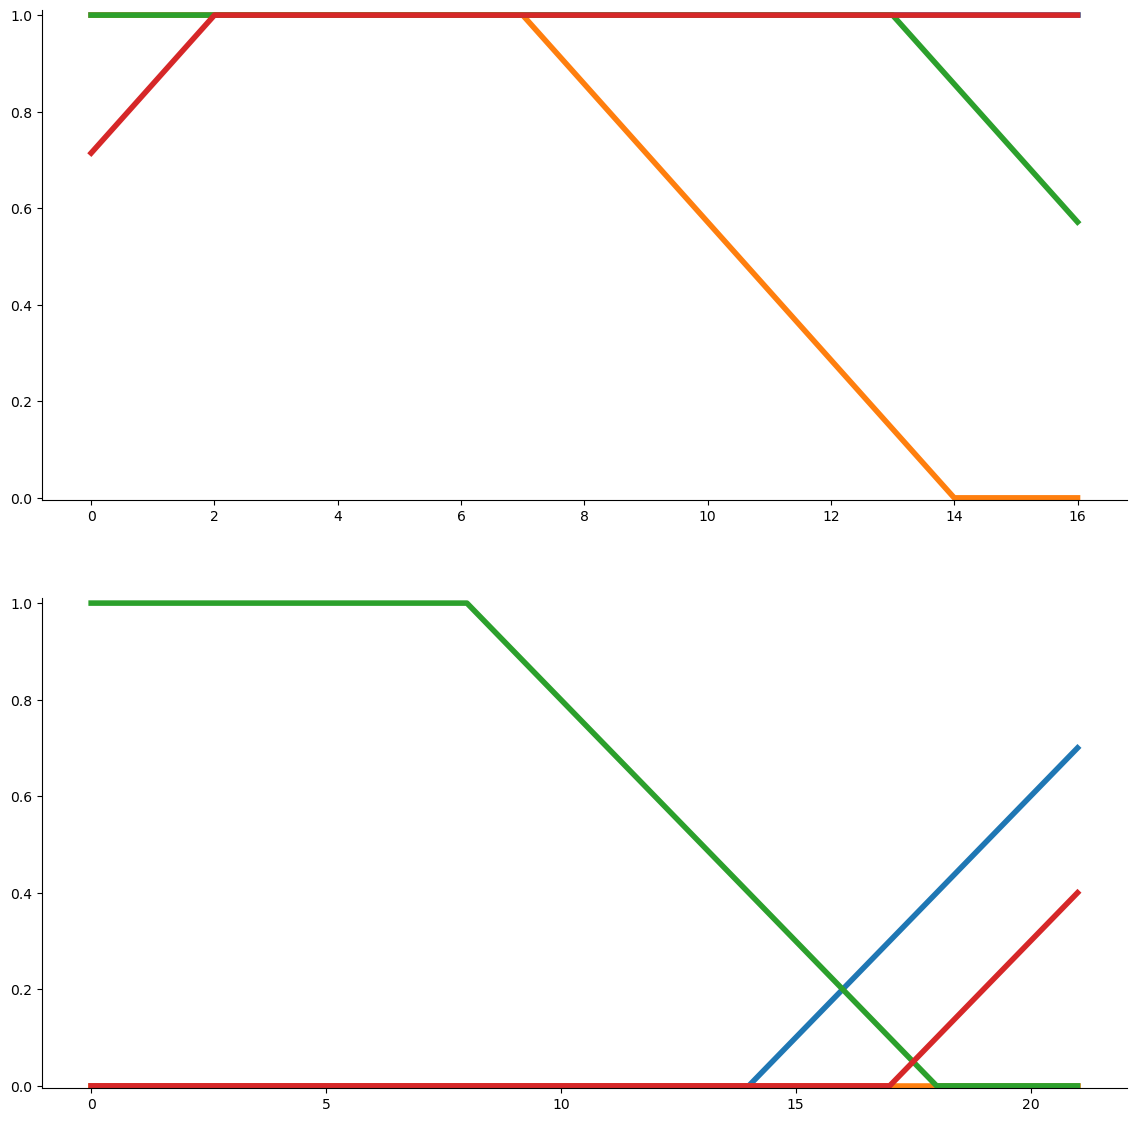

In [16]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(14, 14))


random_genes = np.random.choice(range(genes), 4)
for random_gene in random_genes:
    _ = axs[0].plot(vals_X[random_gene], linewidth=4)
    
for random_gene in random_genes:
    _ = axs[1].plot(vals_Y[random_gene], linewidth=4)

axs[0].spines[['right', 'top']].set_visible(False)
axs[1].spines[['right', 'top']].set_visible(False)
# axs[0].set_xlim([0, 17])
# axs[1].set_xlim([0, 22])
axs[0].set_ylim([-0.005, 1.01])
axs[1].set_ylim([-0.005, 1.01])

plt.savefig("../imgs/test.svg")

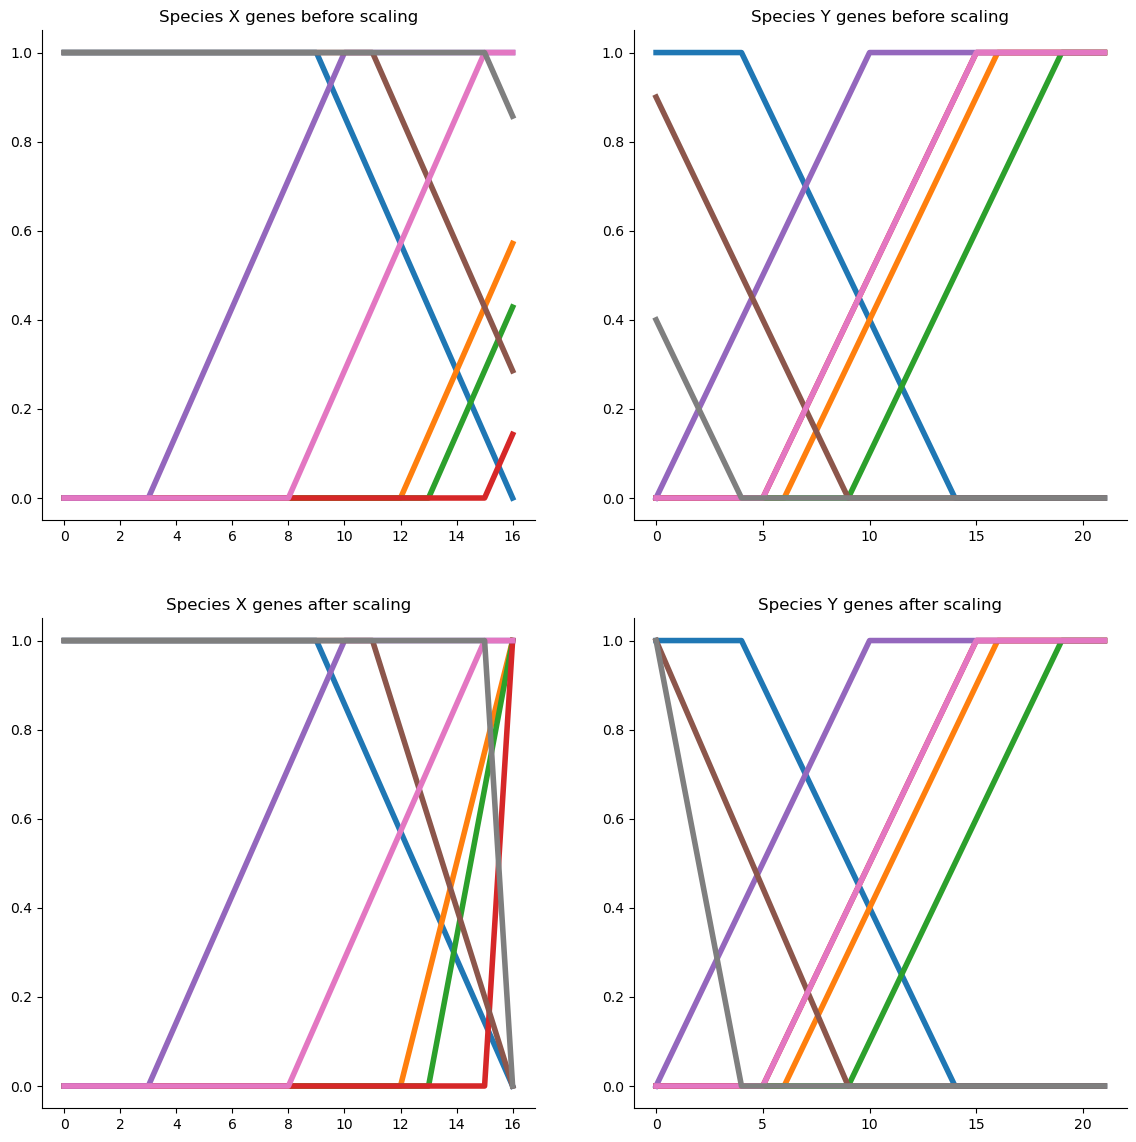

In [17]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 14))


random_genes = np.random.randint(0, vals_X.shape[0], 8)
# random_genes = [3, 4, 5, 6, 251, 252, 253, 254]
for random_gene in random_genes:
    _ = axs[0, 0].plot(vals_X[random_gene], linewidth=4)
    
for random_gene in random_genes:
    _ = axs[0, 1].plot(vals_Y[random_gene], linewidth=4)

for random_gene in random_genes:
    _ = axs[1, 0].plot(sklearn.preprocessing.minmax_scale(vals_X[random_gene]), linewidth=4)
    
for random_gene in random_genes:
    _ = axs[1, 1].plot(sklearn.preprocessing.minmax_scale(vals_Y[random_gene]), linewidth=4)
    

_ = axs[0, 0].set_title("Species X genes before scaling")
_ = axs[0, 1].set_title("Species Y genes before scaling")
_ = axs[1, 0].set_title("Species X genes after scaling")
_ = axs[1, 1].set_title("Species Y genes after scaling")
axs[0, 0].spines[['right', 'top']].set_visible(False)
axs[0, 1].spines[['right', 'top']].set_visible(False)
axs[1, 0].spines[['right', 'top']].set_visible(False)
axs[1, 1].spines[['right', 'top']].set_visible(False)

plt.savefig("../imgs/test.svg")

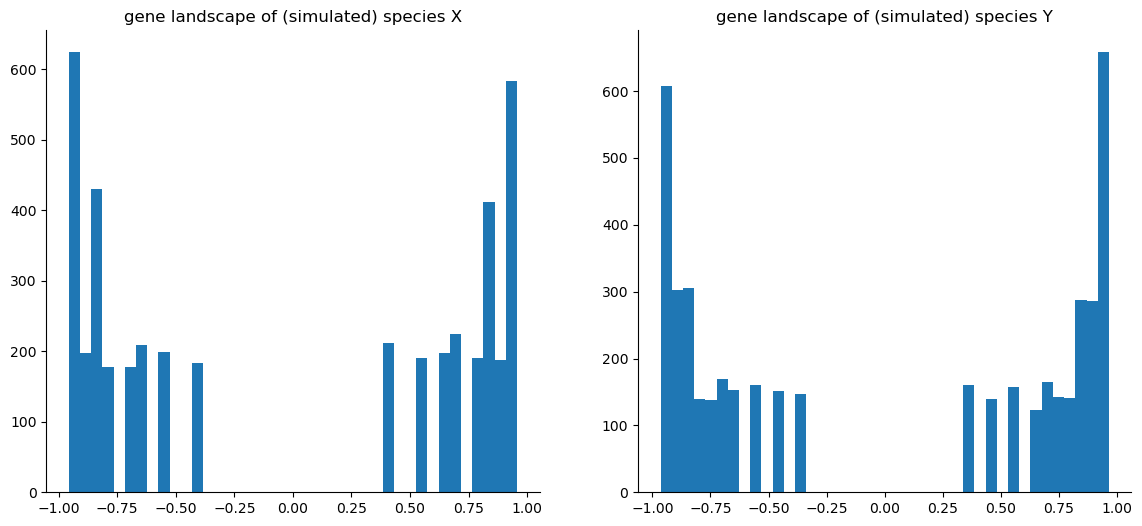

In [18]:
gl_X = gene_landscape(pd.DataFrame(vals_X))
gl_Y = gene_landscape(pd.DataFrame(vals_Y))

fig, axs = plt.subplots(ncols=2, figsize=(14, 6))

_ = axs[0].hist(gl_X["late"], bins=40)
_ = axs[1].hist(gl_Y["late"], bins=40)
_ = axs[0].set_title("gene landscape of (simulated) species X")
_ = axs[1].set_title("gene landscape of (simulated) species Y")
axs[0].spines[['right', 'top']].set_visible(False)
axs[1].spines[['right', 'top']].set_visible(False)

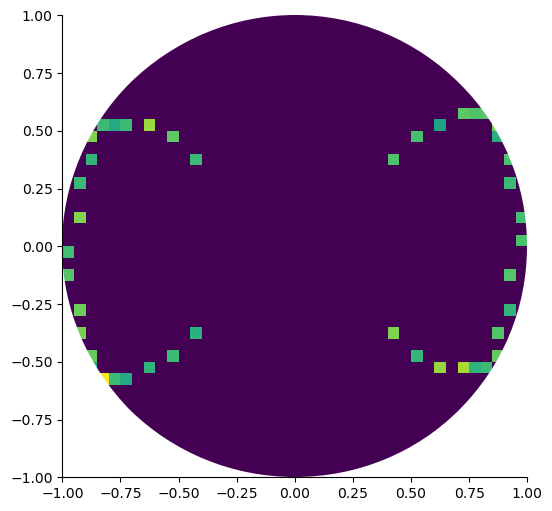

In [19]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(6, 6))


im = ax.hist2d(gl_X["late"], gl_X["mid-development"], range=[[-1, 1], [-1, 1]], bins=40)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
patch = patches.Circle((0, 0), radius=1, transform=ax.transData)
im[-1].set_clip_path(patch)
ax.spines[['right', 'top']].set_visible(False)

In [20]:
gl_X

,late,mid-development
0,0.766064,-0.536280
1,0.957191,0.145104
2,0.897309,-0.379656
3,0.947231,-0.135801
4,0.816335,0.566845
...,...,...
4995,-0.858395,0.462243
4996,-0.858395,-0.539283
4997,-0.631933,0.525909
4998,-0.927249,0.266918


In [21]:
vals_X

array([[0.        , 0.        , 0.        , ..., 0.42857143, 0.57142857,
        0.71428571],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.85714286, 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.85714286, 0.71428571,
        0.57142857],
       [1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ]])

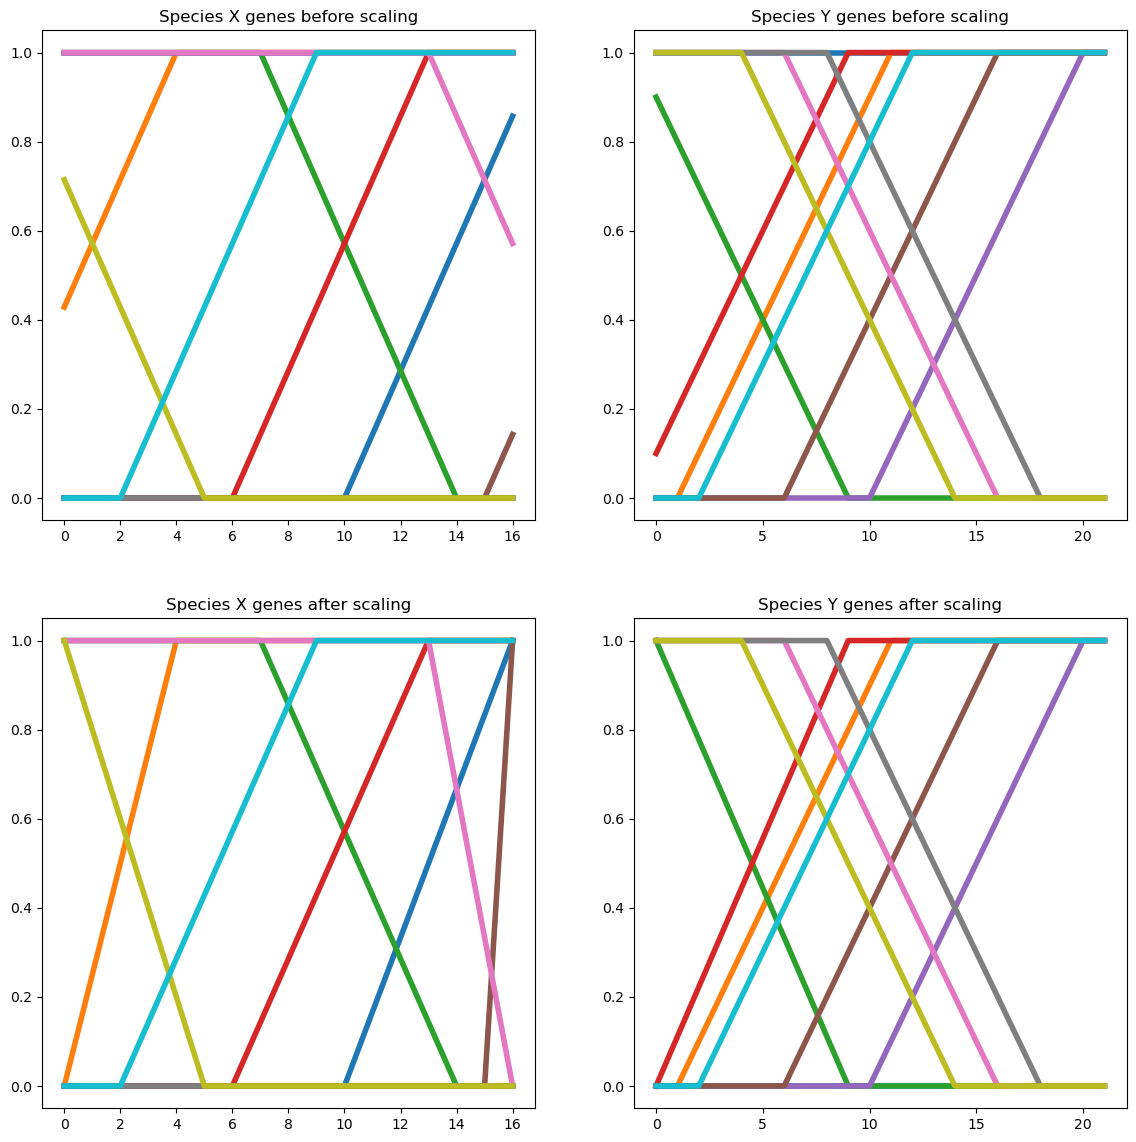

In [22]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 14))


random_genes = np.random.randint(0, vals_X.shape[0], 10)
for random_gene in random_genes:
    _ = axs[0, 0].plot(vals_X[random_gene], linewidth=4)
    
for random_gene in random_genes:
    _ = axs[0, 1].plot(vals_Y[random_gene], linewidth=4)

for random_gene in random_genes:
    _ = axs[1, 0].plot(sklearn.preprocessing.minmax_scale(vals_X[random_gene]), linewidth=4)
    
for random_gene in random_genes:
    _ = axs[1, 1].plot(sklearn.preprocessing.minmax_scale(vals_Y[random_gene]), linewidth=4)
    

_ = axs[0, 0].set_title("Species X genes before scaling")
_ = axs[0, 1].set_title("Species Y genes before scaling")
_ = axs[1, 0].set_title("Species X genes after scaling")
_ = axs[1, 1].set_title("Species Y genes after scaling")

### Pairwise comparison between all timepoints between species X and Y

If we visualize the correlation coefficient between all timepoints, we get a smooth diagonal within a species. However, in between species, we get the inverse hourglass as described [here](https://www.nature.com/articles/nature16994). Note that the switch falls exactly in the middle for our simulated data, but also in the paper of levin et al.

The inverse hourglass between species can intuitively be understood as that in the beginning of the time series there is a lot of overlap, and in the end as well. This is because the same genes are still high/low between species. However as time progresses, some genes start switching, and the correlation between species gets lost.

note that even though the same colors are used between plots, the correlation coefficients for the between species comparison are much lower. 

0.5545115797526236 -0.5001853710125013


Text(0.5, 0, 'Species Y')

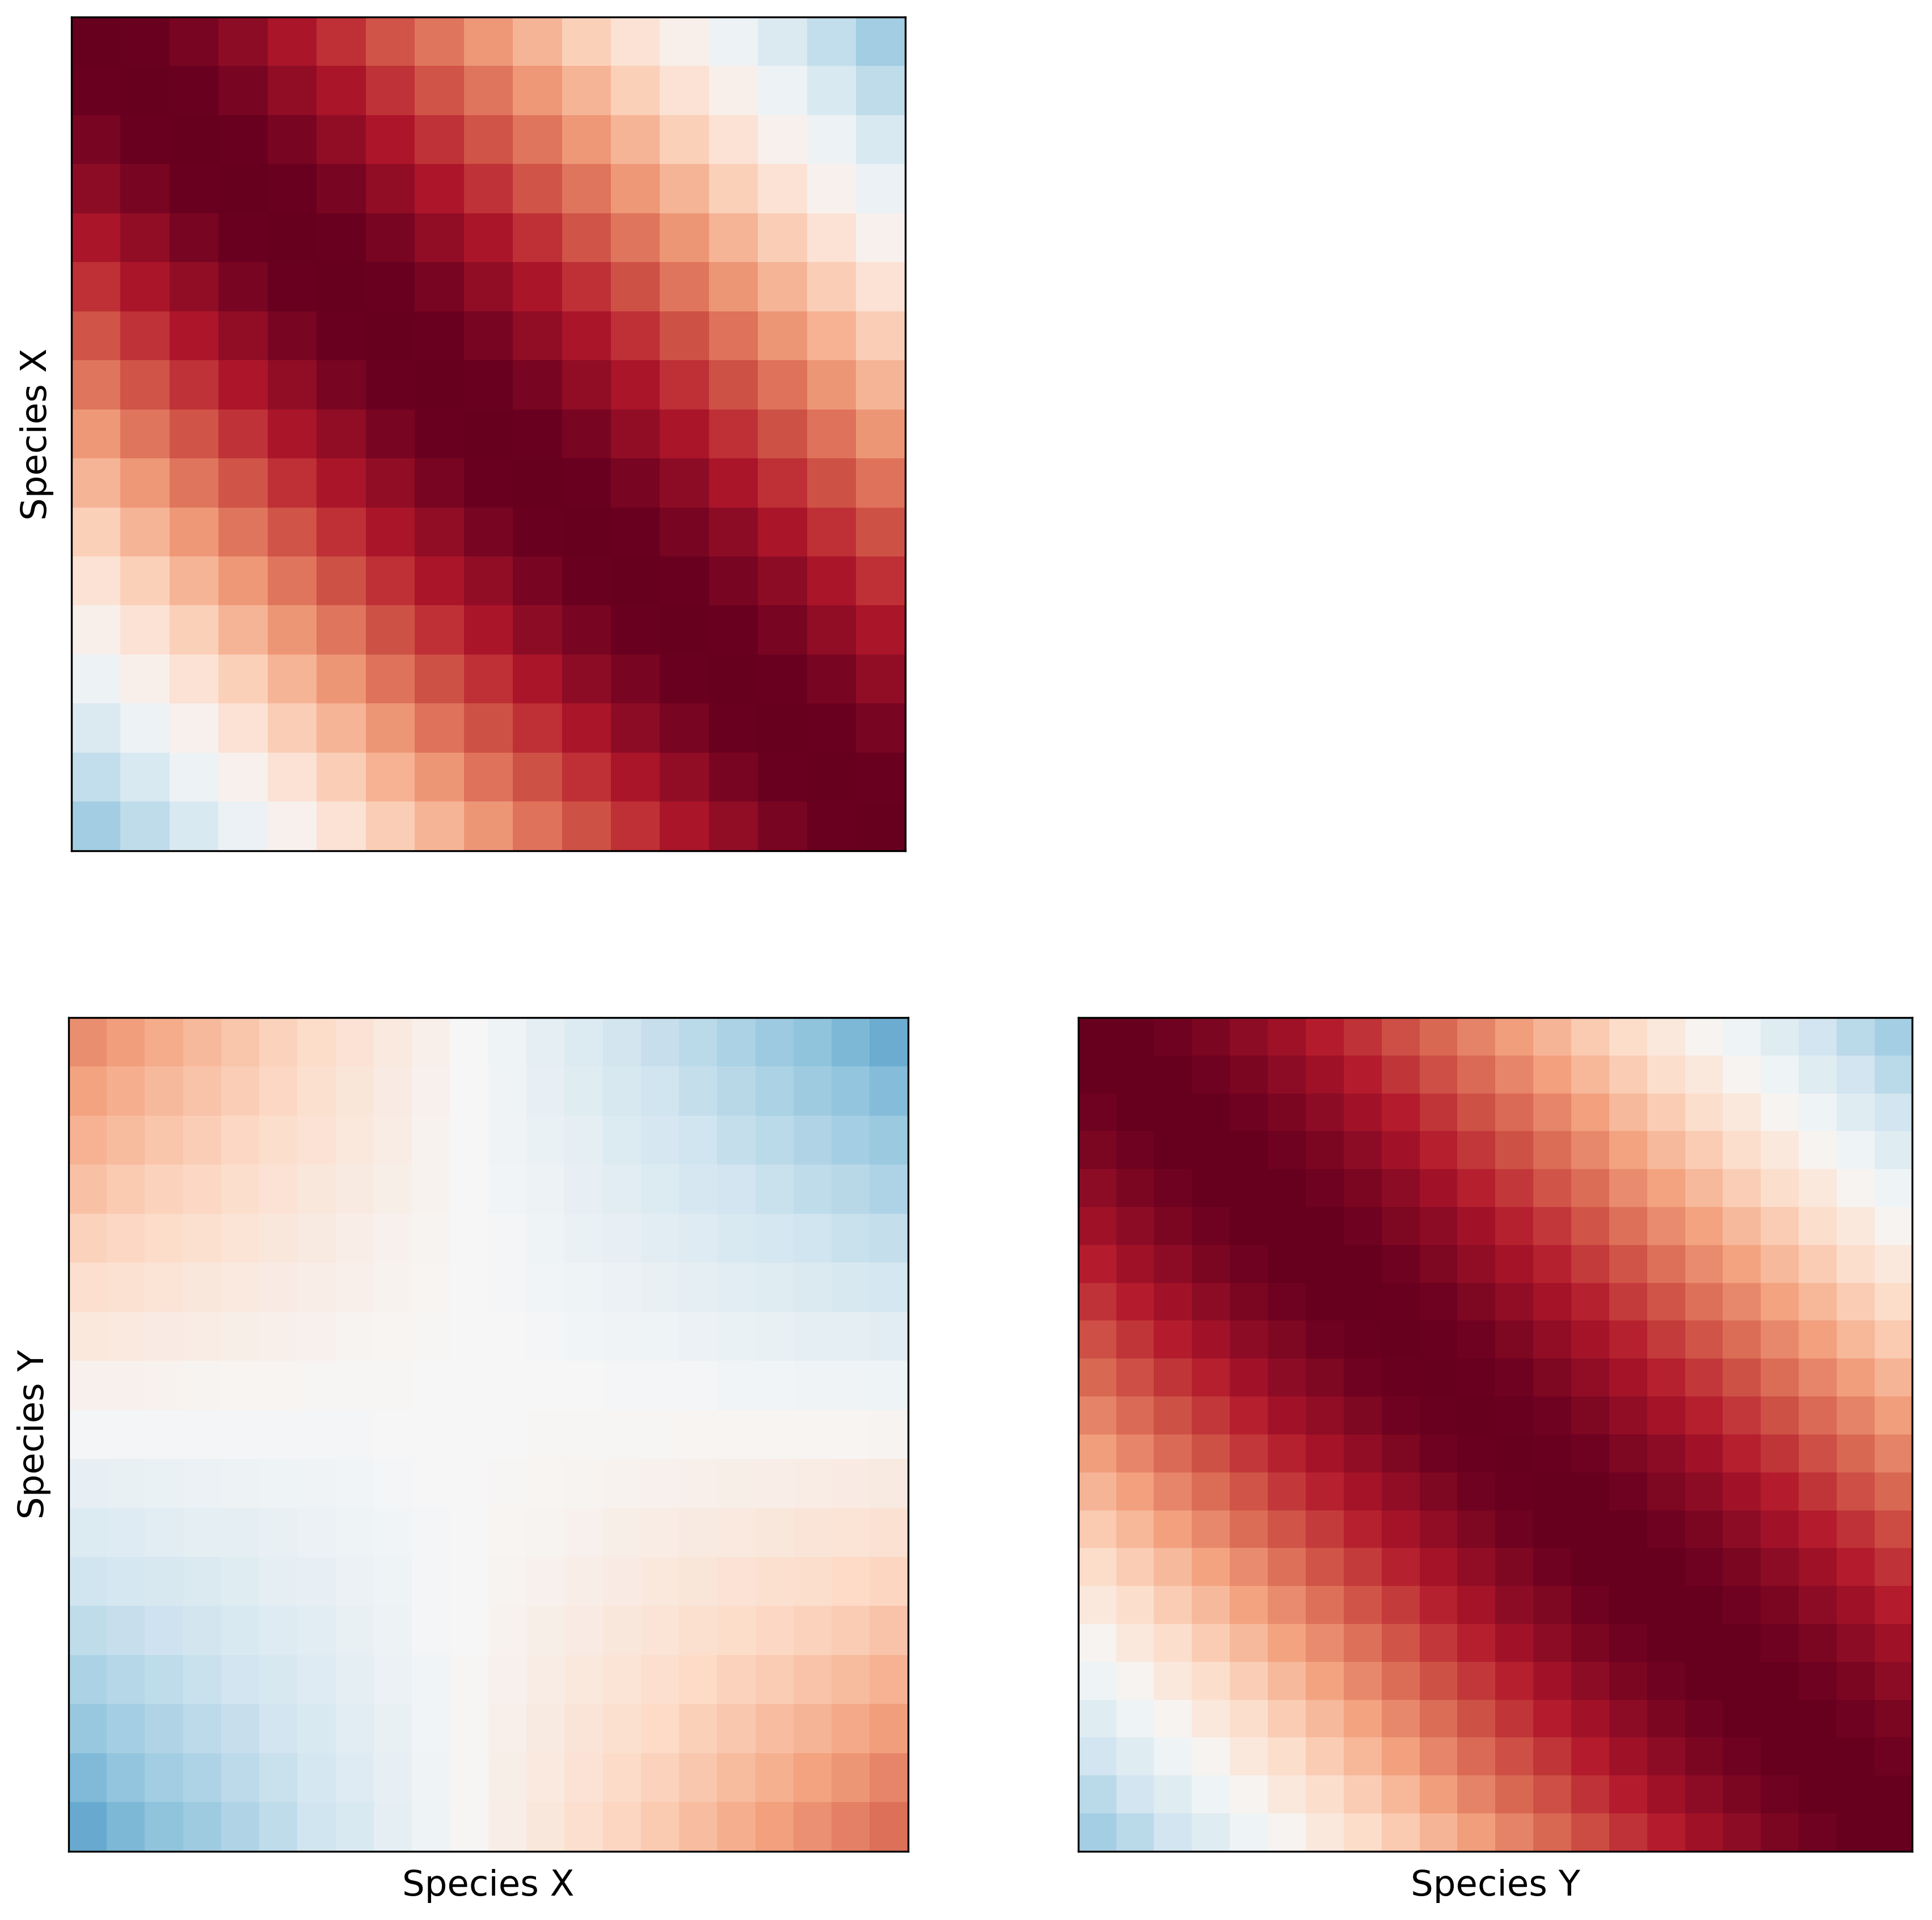

In [23]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 14), dpi=300)
axs[0, 1].axis('off')
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])


# scale
vals_X_scaled = vals_X
vals_Y_scaled = vals_Y
# vals_X_scaled = sklearn.preprocessing.minmax_scale(vals_X, axis=1)
# vals_Y_scaled = sklearn.preprocessing.minmax_scale(vals_Y, axis=1)
# vals_X_scaled = scipy.stats.zscore(vals_X, axis=1)
# vals_Y_scaled = scipy.stats.zscore(vals_Y, axis=1)

correct_orthos = np.all(~np.isnan(vals_X_scaled), axis=1) & np.all(~np.isnan(vals_Y_scaled), axis=1)

vals_X_scaled = vals_X_scaled[correct_orthos]
vals_Y_scaled = vals_Y_scaled[correct_orthos]

corrs = np.zeros((vals_X_scaled.shape[1], vals_X_scaled.shape[1]))
for i in range(vals_X_scaled.shape[1]):
    for j in range(vals_X_scaled.shape[1]):
#         corrs[i, j] = stats.spearmanr(vals_X_scaled[:, i], vals_X_scaled[:, j])[0]
        corrs[i, j] = np.corrcoef(vals_X_scaled[:, i], vals_X_scaled[:, j])[0, 1]
#         corrs[i, j] = -np.linalg.norm(vals_X_scaled[:, i] - vals_X_scaled[:, j])
#         corrs[i, j] = -jensen_shannon_distance(vals_X_scaled[:, i], vals_X_scaled[:, j])
axs[0, 0].imshow(corrs, cmap="RdBu_r", interpolation='None', vmin=-1, vmax=1)
axs[0, 0].set_ylabel("""Species X""")


corrs = np.zeros((vals_X_scaled.shape[1], vals_Y_scaled.shape[1]))
for i in range(vals_X_scaled.shape[1]):
    for j in range(vals_Y_scaled.shape[1]):
#         corrs[i, j] = stats.spearmanr(vals_X_scaled[:, i], vals_Y_scaled[:, j])[0]
        corrs[i, j] = np.corrcoef(vals_X_scaled[:, i], vals_Y_scaled[:, j])[0, 1]
#         corrs[i, j] = -np.linalg.norm(vals_X_scaled[:, i] - vals_Y_scaled[:, j])
#         corrs[i, j] = -jensen_shannon_distance(vals_X_scaled[:, i], vals_Y_scaled[:, j])

# vals_X_scaled = pd.DataFrame(vals_X_scaled)
# vals_Y_scaled = pd.DataFrame(vals_Y_scaled)
# corrs = pairwise_pearson(vals_X_scaled, vals_Y_scaled)

axs[1, 0].imshow(corrs, cmap="RdBu_r", interpolation='None', aspect="auto", vmin=-1, vmax=1)
axs[1, 0].set_xlabel("""Species X""")
axs[1, 0].set_ylabel("""Species Y""")

print(np.max(corrs), np.min(corrs))

corrs = np.zeros((vals_Y_scaled.shape[1], vals_Y_scaled.shape[1]))
for i in range(vals_Y_scaled.shape[1]):
    for j in range(vals_Y_scaled.shape[1]):
#         corrs[i, j] = stats.spearmanr(vals_Y_scaled[:, i], vals_Y_scaled[:, j])[0]
        corrs[i, j] = np.corrcoef(vals_Y_scaled[:, i], vals_Y_scaled[:, j])[0, 1]
#         corrs[i, j] = -np.linalg.norm(vals_Y_scaled[:, i] - vals_Y_scaled[:, j])
#         corrs[i, j] = -jensen_shannon_distance(vals_Y_scaled[:, i], vals_Y_scaled[:, j])
axs[1, 1].imshow(corrs, cmap="RdBu_r", interpolation='None', vmin=-1, vmax=1)
axs[1, 1].set_xlabel("""Species Y""")

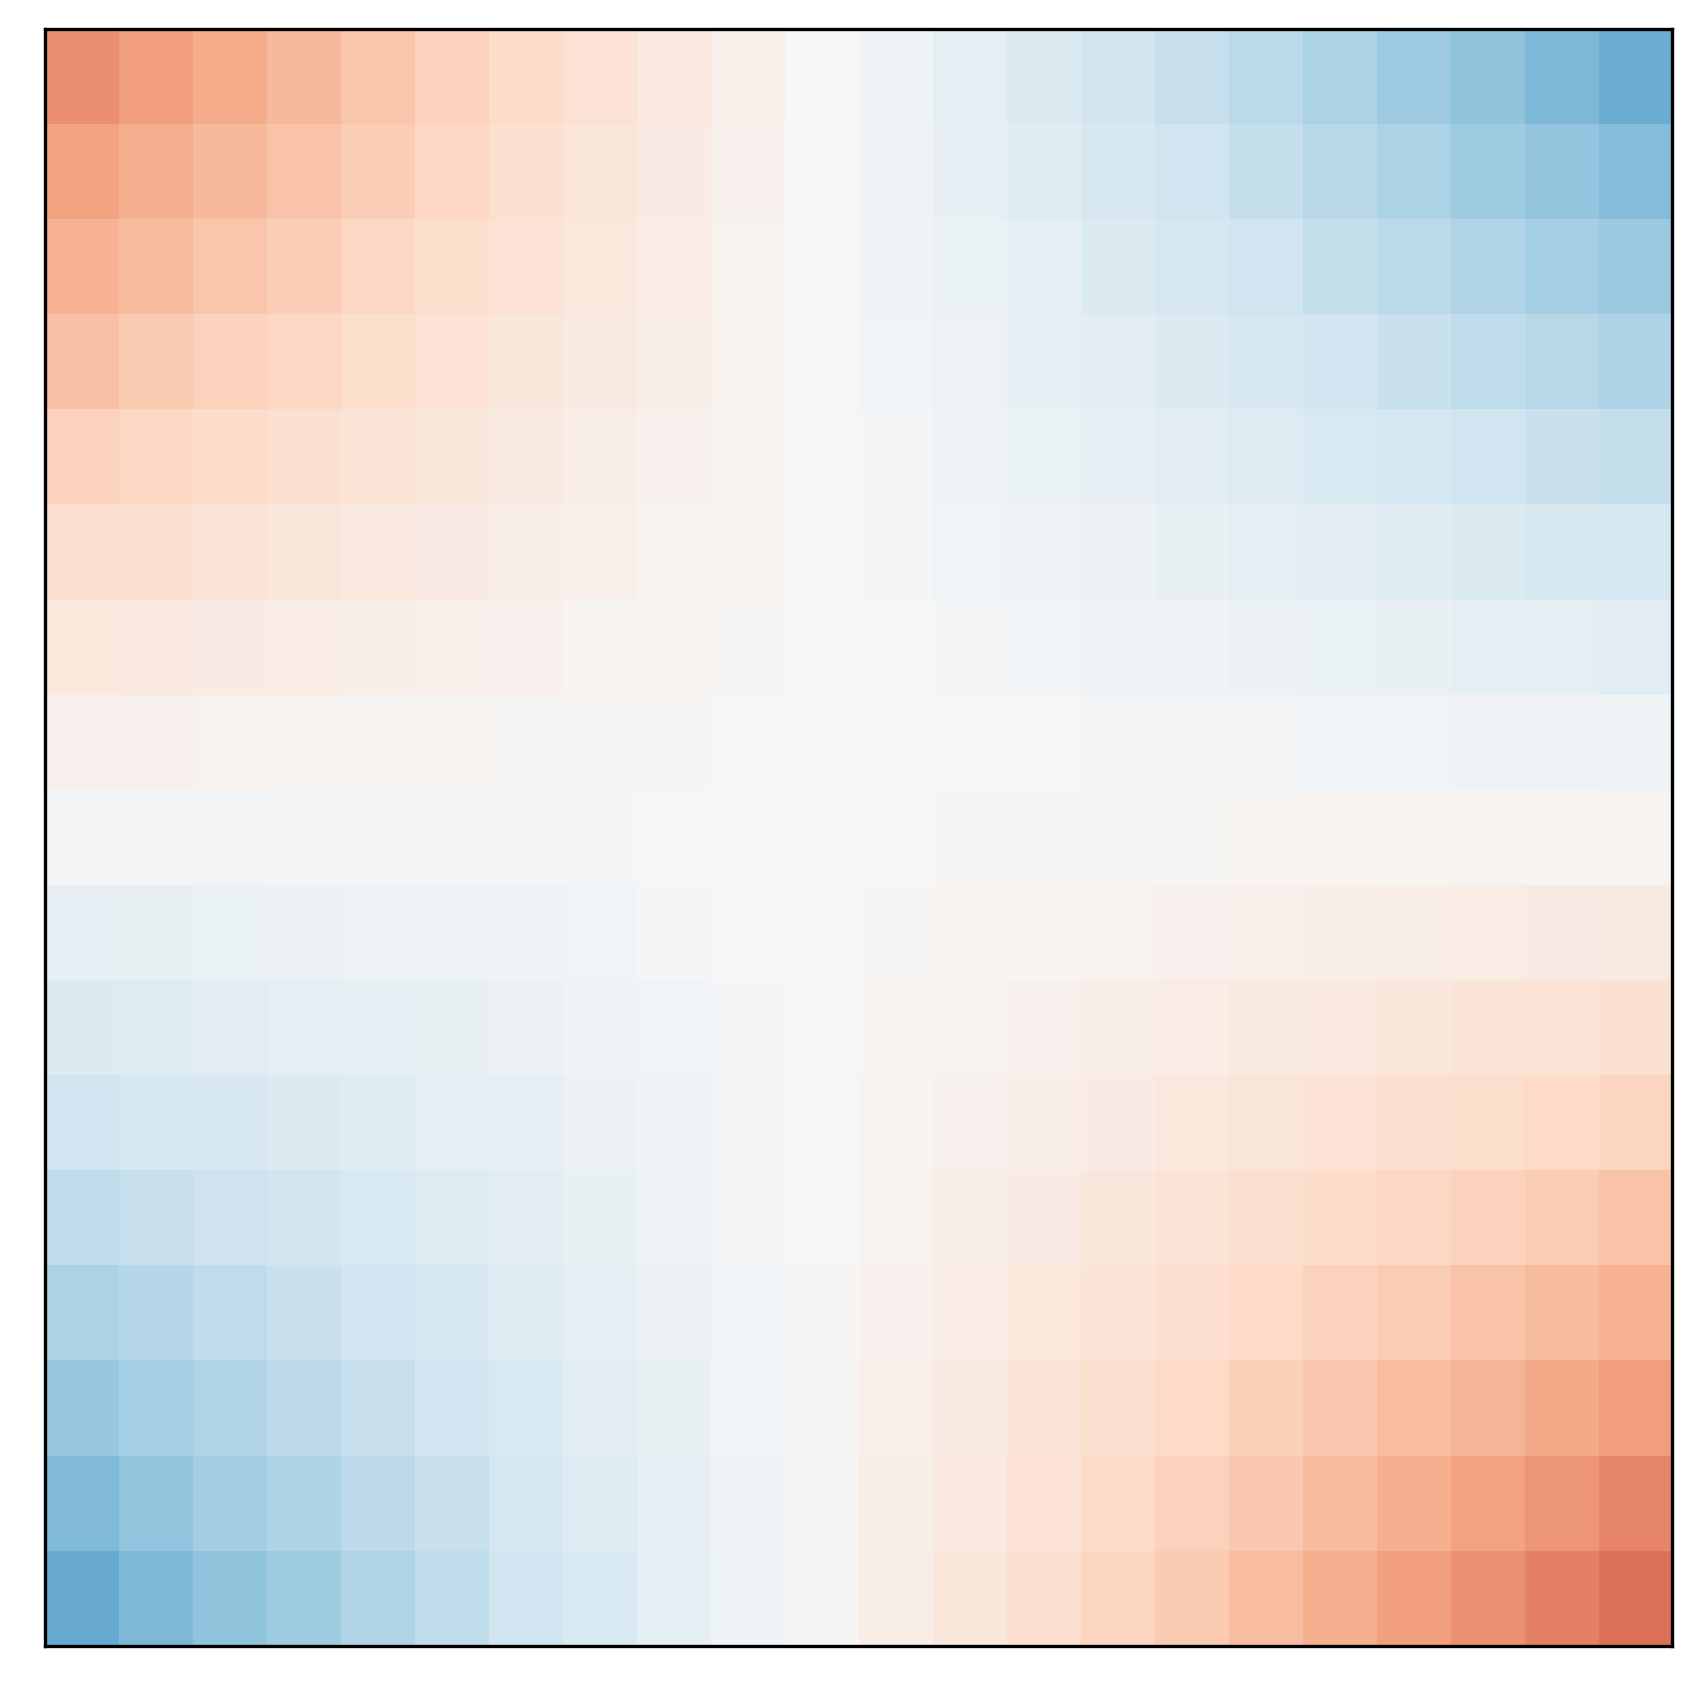

In [24]:
vals_X_scaled = pd.DataFrame(vals_X_scaled)
vals_Y_scaled = pd.DataFrame(vals_Y_scaled)
corrs = pairwise_pearson(vals_X_scaled, vals_Y_scaled)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 7), dpi=300)

ax.set_xticks([])
ax.set_yticks([])

ax.imshow(corrs, cmap="RdBu_r", interpolation='None', aspect="auto", vmin=-1, vmax=1)
plt.savefig("../imgs/sim_imshow.svg")

(5000, 8) (5000, 17)
0.8111163585080621 -0.002257760923075964
(5000, 8) (5000, 17)
-0.009640996847549904 -0.8040505924226625
(5000, 9) (5000, 17)
0.017246029967915247 -0.8086038112742295
(5000, 9) (5000, 17)
0.8011257305576747 -0.019152038758386846


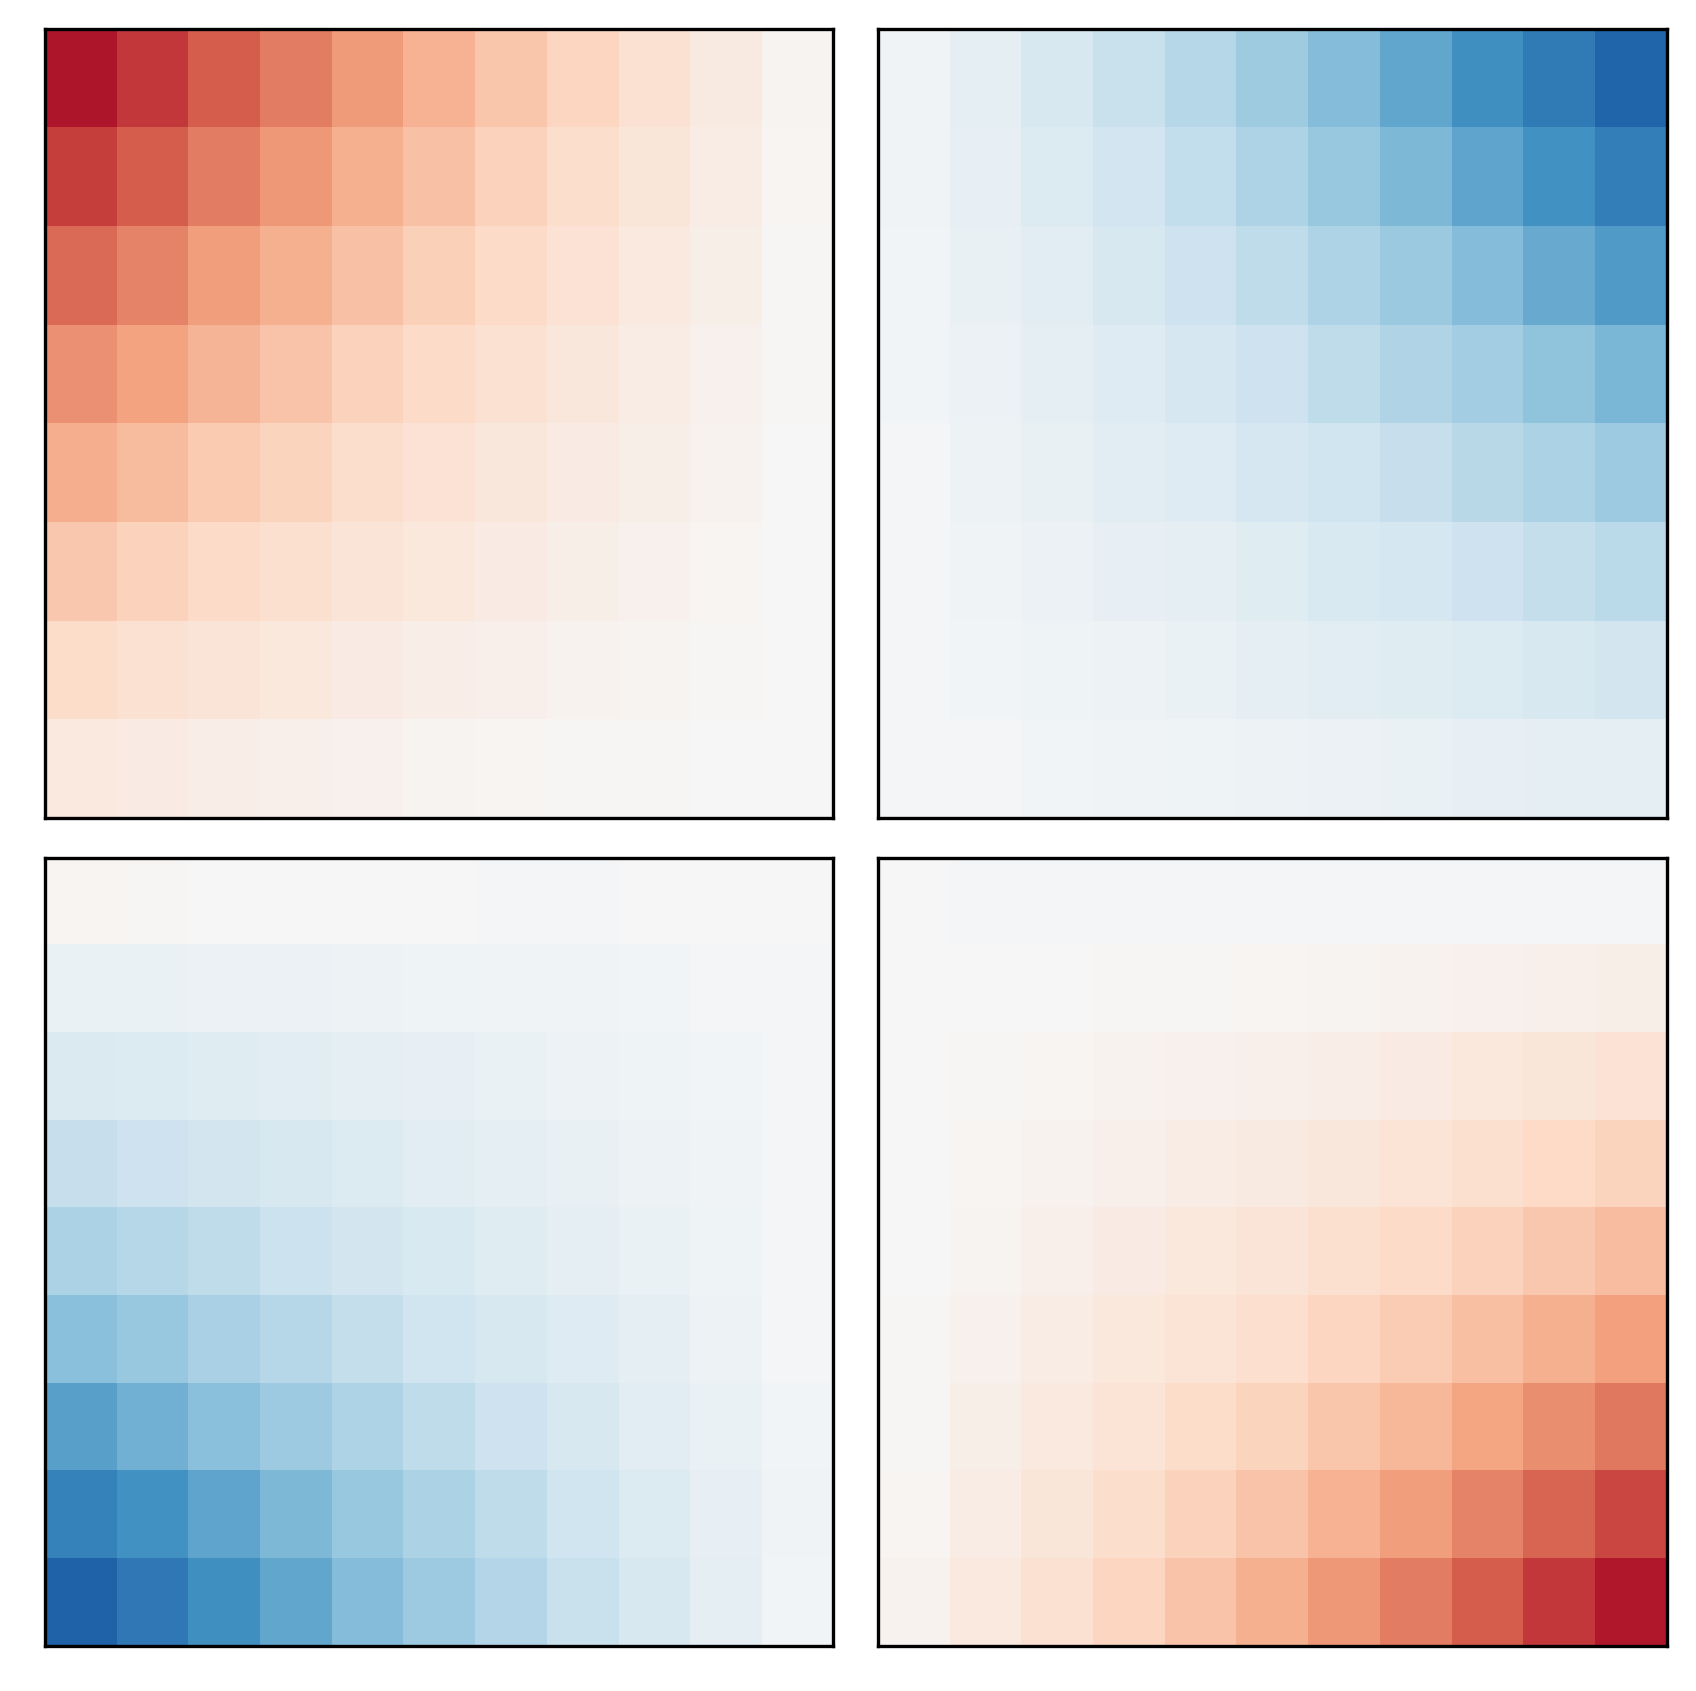

In [25]:
fig, axes = plt.subplots(figsize=(7, 7), nrows=2, ncols=2, dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)

vals_X_rescaled = sklearn.preprocessing.minmax_scale(vals_X, axis=1)
vals_Y_rescaled = sklearn.preprocessing.minmax_scale(vals_Y, axis=1)


for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        
        if i == 0:
            vals_X_scaled = vals_X_rescaled[:, :vals_X.shape[1] // 2]
        else:
            vals_X_scaled = vals_X_rescaled[:, vals_X.shape[1] // 2:]

        if j == 0:
            vals_Y_scaled = vals_Y_rescaled[:, :vals_Y.shape[1] // 2]
        else:
            vals_Y_scaled = vals_Y_rescaled[:, vals_Y.shape[1] // 2:]

        print(vals_X_scaled.shape, vals_X.shape)
#         vals_X_scaled = scipy.stats.zscore(vals_X_scaled, axis=1)
#         vals_Y_scaled = scipy.stats.zscore(vals_Y_scaled, axis=1)
        correct_orthos = np.all(~np.isnan(vals_X_scaled), axis=1) & np.all(~np.isnan(vals_Y_scaled), axis=1)

        vals_X_scaled = pd.DataFrame(vals_X_scaled[correct_orthos])
        vals_Y_scaled = pd.DataFrame(vals_Y_scaled[correct_orthos])

        corr_matrix = pairwise_pearson(vals_X_scaled, vals_Y_scaled)
        print(np.max(corr_matrix), np.min(corr_matrix))
        stages_X = vals_X_scaled.columns
        stages_Y = vals_Y_scaled.columns
        
        img = ax.imshow(corr_matrix, origin='upper', cmap="RdBu_r", interpolation='None', 
                        aspect=len(stages_Y)/len(stages_X),
                        vmin=-1, vmax=1)

        ax.set_xticks([])
        ax.set_yticks([])
#         if j == 0:
#             ax.set_yticks(range(len(stages_X)))
#             ax.set_yticklabels(stages_X)
#         if i == 1:
#             ax.set_xticks(range(len(stages_Y)))
#             ax.set_xticklabels(stages_Y)

#         fontsize = 14
#         _ = plt.setp(ax.get_xticklabels(), rotation=90, ha='center', fontsize=fontsize)
#         _ = plt.setp(ax.get_yticklabels(), fontsize=fontsize)

plt.savefig("../imgs/sim_inverse_half.svg")

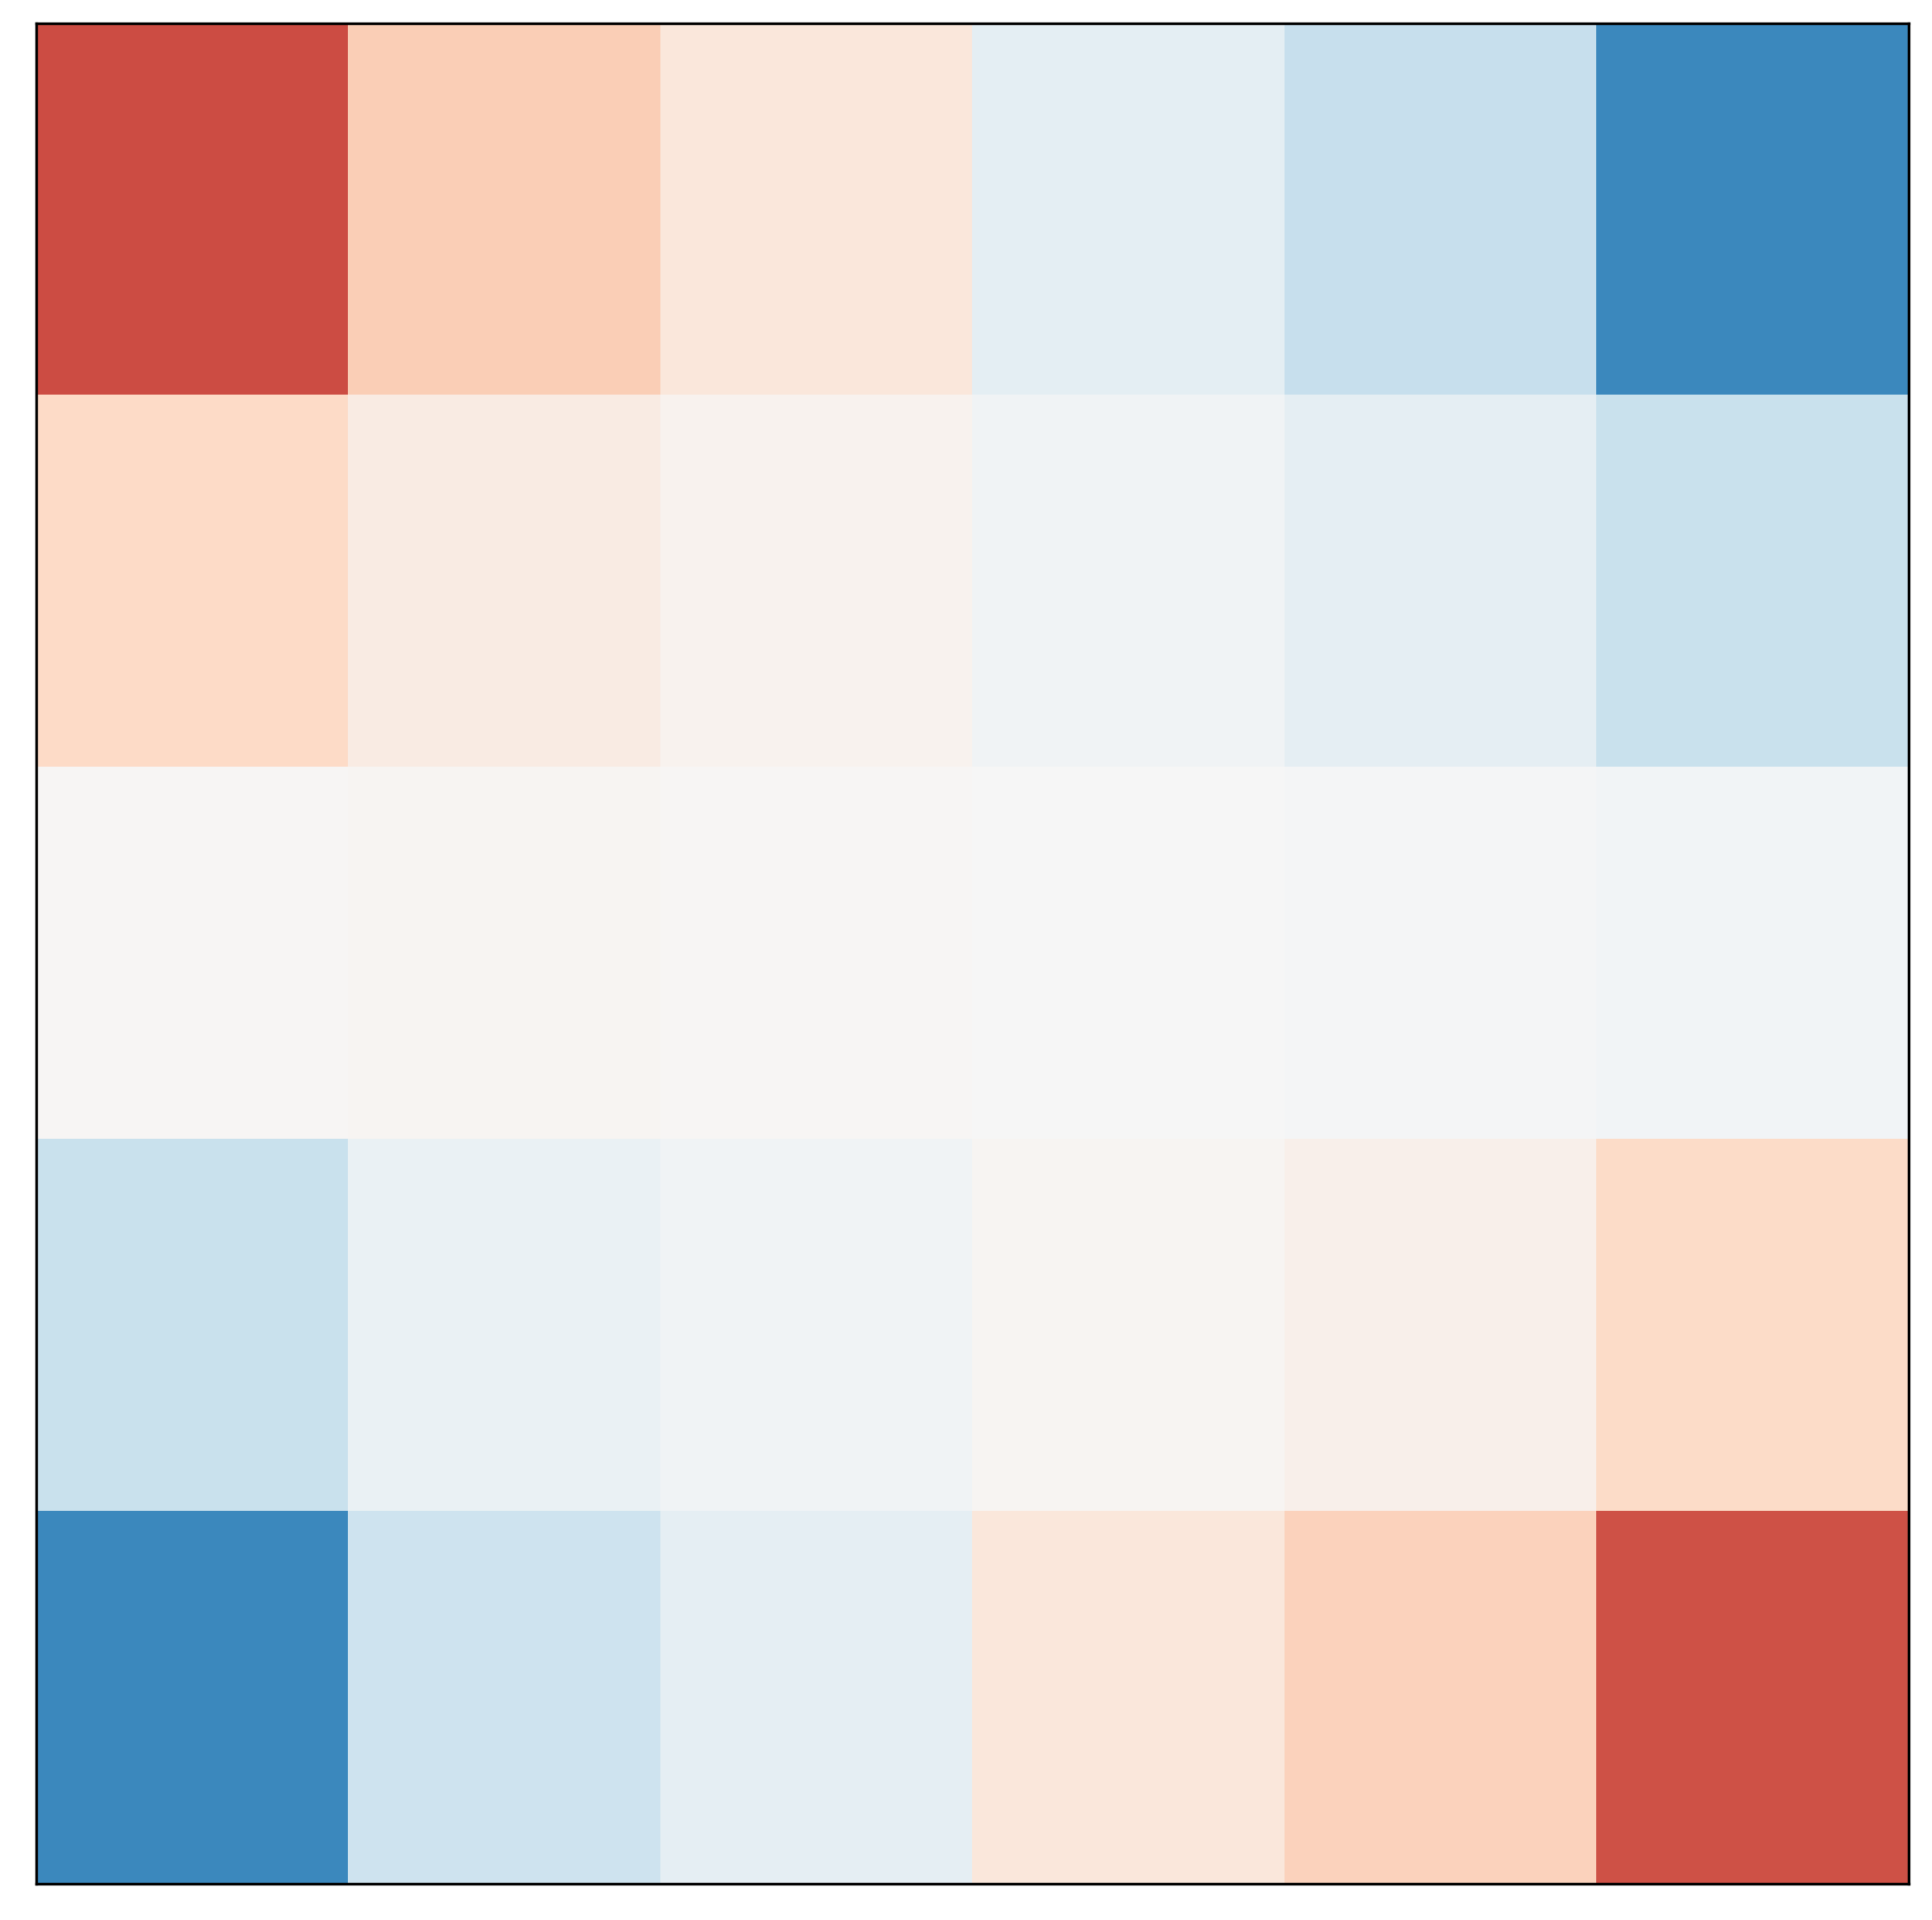

In [26]:
from util import pairwise_pearson

plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

vals_X_scaled = vals_X.copy()
vals_Y_scaled = vals_Y.copy()

# vals_X_scaled = vals_X_scaled[:, vals_X_scaled.shape[1] // 2:]
# vals_Y_scaled = vals_Y_scaled[:, vals_Y_scaled.shape[1] // 2:]
vals_X_scaled = vals_X_scaled[:, vals_X_scaled.shape[1] // 2 + vals_X_scaled.shape[1] // 4:]
vals_Y_scaled = vals_Y_scaled[:, vals_Y_scaled.shape[1] // 2 + vals_Y_scaled.shape[1] // 4:]
vals_X_scaled = sklearn.preprocessing.minmax_scale(vals_X_scaled, axis=1)
vals_Y_scaled = sklearn.preprocessing.minmax_scale(vals_Y_scaled, axis=1)


corrs = np.zeros((vals_X_scaled.shape[1], vals_Y_scaled.shape[1]))

for i in range(vals_X_scaled.shape[1]):
    for j in range(vals_Y_scaled.shape[1]):
        corrs[i, j] = stats.spearmanr(vals_X_scaled[:, i], vals_Y_scaled[:, j])[0]

aspect = "auto"
img = ax.imshow(corrs, origin='upper', cmap="RdBu_r", interpolation='None', aspect=aspect, vmin=-0.4, vmax=0.4)

ax.set_xticks([])
ax.set_yticks([])

plt.savefig("../imgs/test.svg")

# What if we take only the first half of this time series?

The switch happens exactly in the middle of the time series, even for the real biological data of levin et al. What happens if we take a different time series? Let's remove the second half of our time series, and see how that influences the figures.

In [27]:
# cut in half
vals_X_halved = vals_X[:, :5]
vals_Y_halved = vals_Y[:, :5]

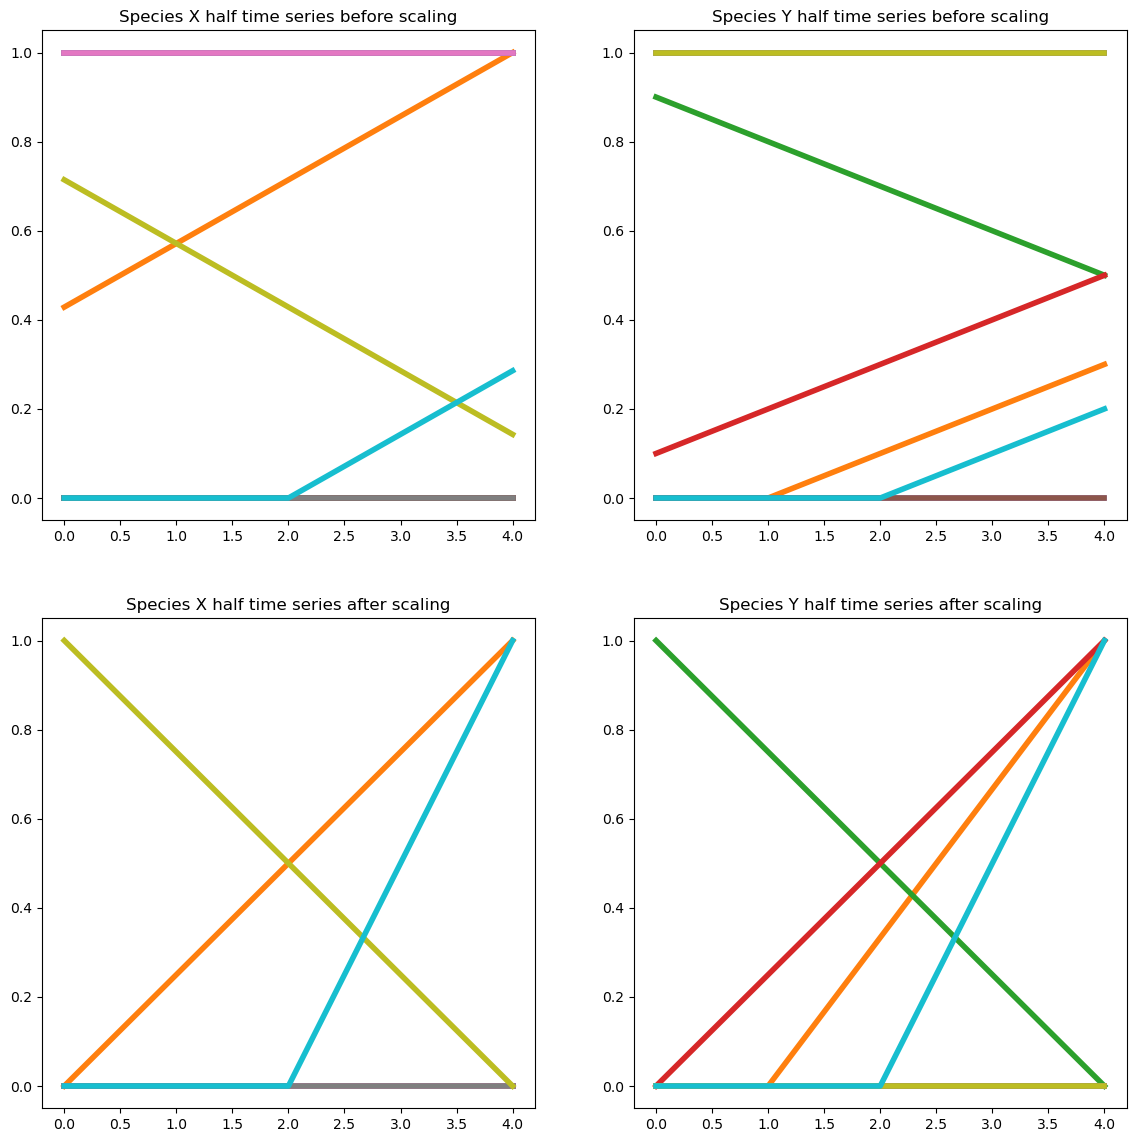

In [28]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 14))

for random_gene in random_genes:
    _ = axs[0, 0].plot(vals_X_halved[random_gene], linewidth=4)
    
for random_gene in random_genes:
    _ = axs[0, 1].plot(vals_Y_halved[random_gene], linewidth=4)

for random_gene in random_genes:
    _ = axs[1, 0].plot(sklearn.preprocessing.minmax_scale(vals_X_halved[random_gene]), linewidth=4)
    
for random_gene in random_genes:
    _ = axs[1, 1].plot(sklearn.preprocessing.minmax_scale(vals_Y_halved[random_gene]), linewidth=4)
    

_ = axs[0, 0].set_title("Species X half time series before scaling")
_ = axs[0, 1].set_title("Species Y half time series before scaling")
_ = axs[1, 0].set_title("Species X half time series after scaling")
_ = axs[1, 1].set_title("Species Y half time series after scaling")

## Unscaled half of the time series

If we just cut the data in half, we get the exact same figures, but just the first half of the time series. As expected!

/vol/phylotypic_hourglass/notebooks/util.py:183: RuntimeWarning: invalid value encountered in divide
  kl_div = lambda x,y: np.nansum(x * np.log2(x/y))
/vol/phylotypic_hourglass/notebooks/util.py:183: RuntimeWarning: divide by zero encountered in log2
  kl_div = lambda x,y: np.nansum(x * np.log2(x/y))
/vol/phylotypic_hourglass/notebooks/util.py:183: RuntimeWarning: invalid value encountered in multiply
  kl_div = lambda x,y: np.nansum(x * np.log2(x/y))


Text(0.5, 0, 'Species Y')

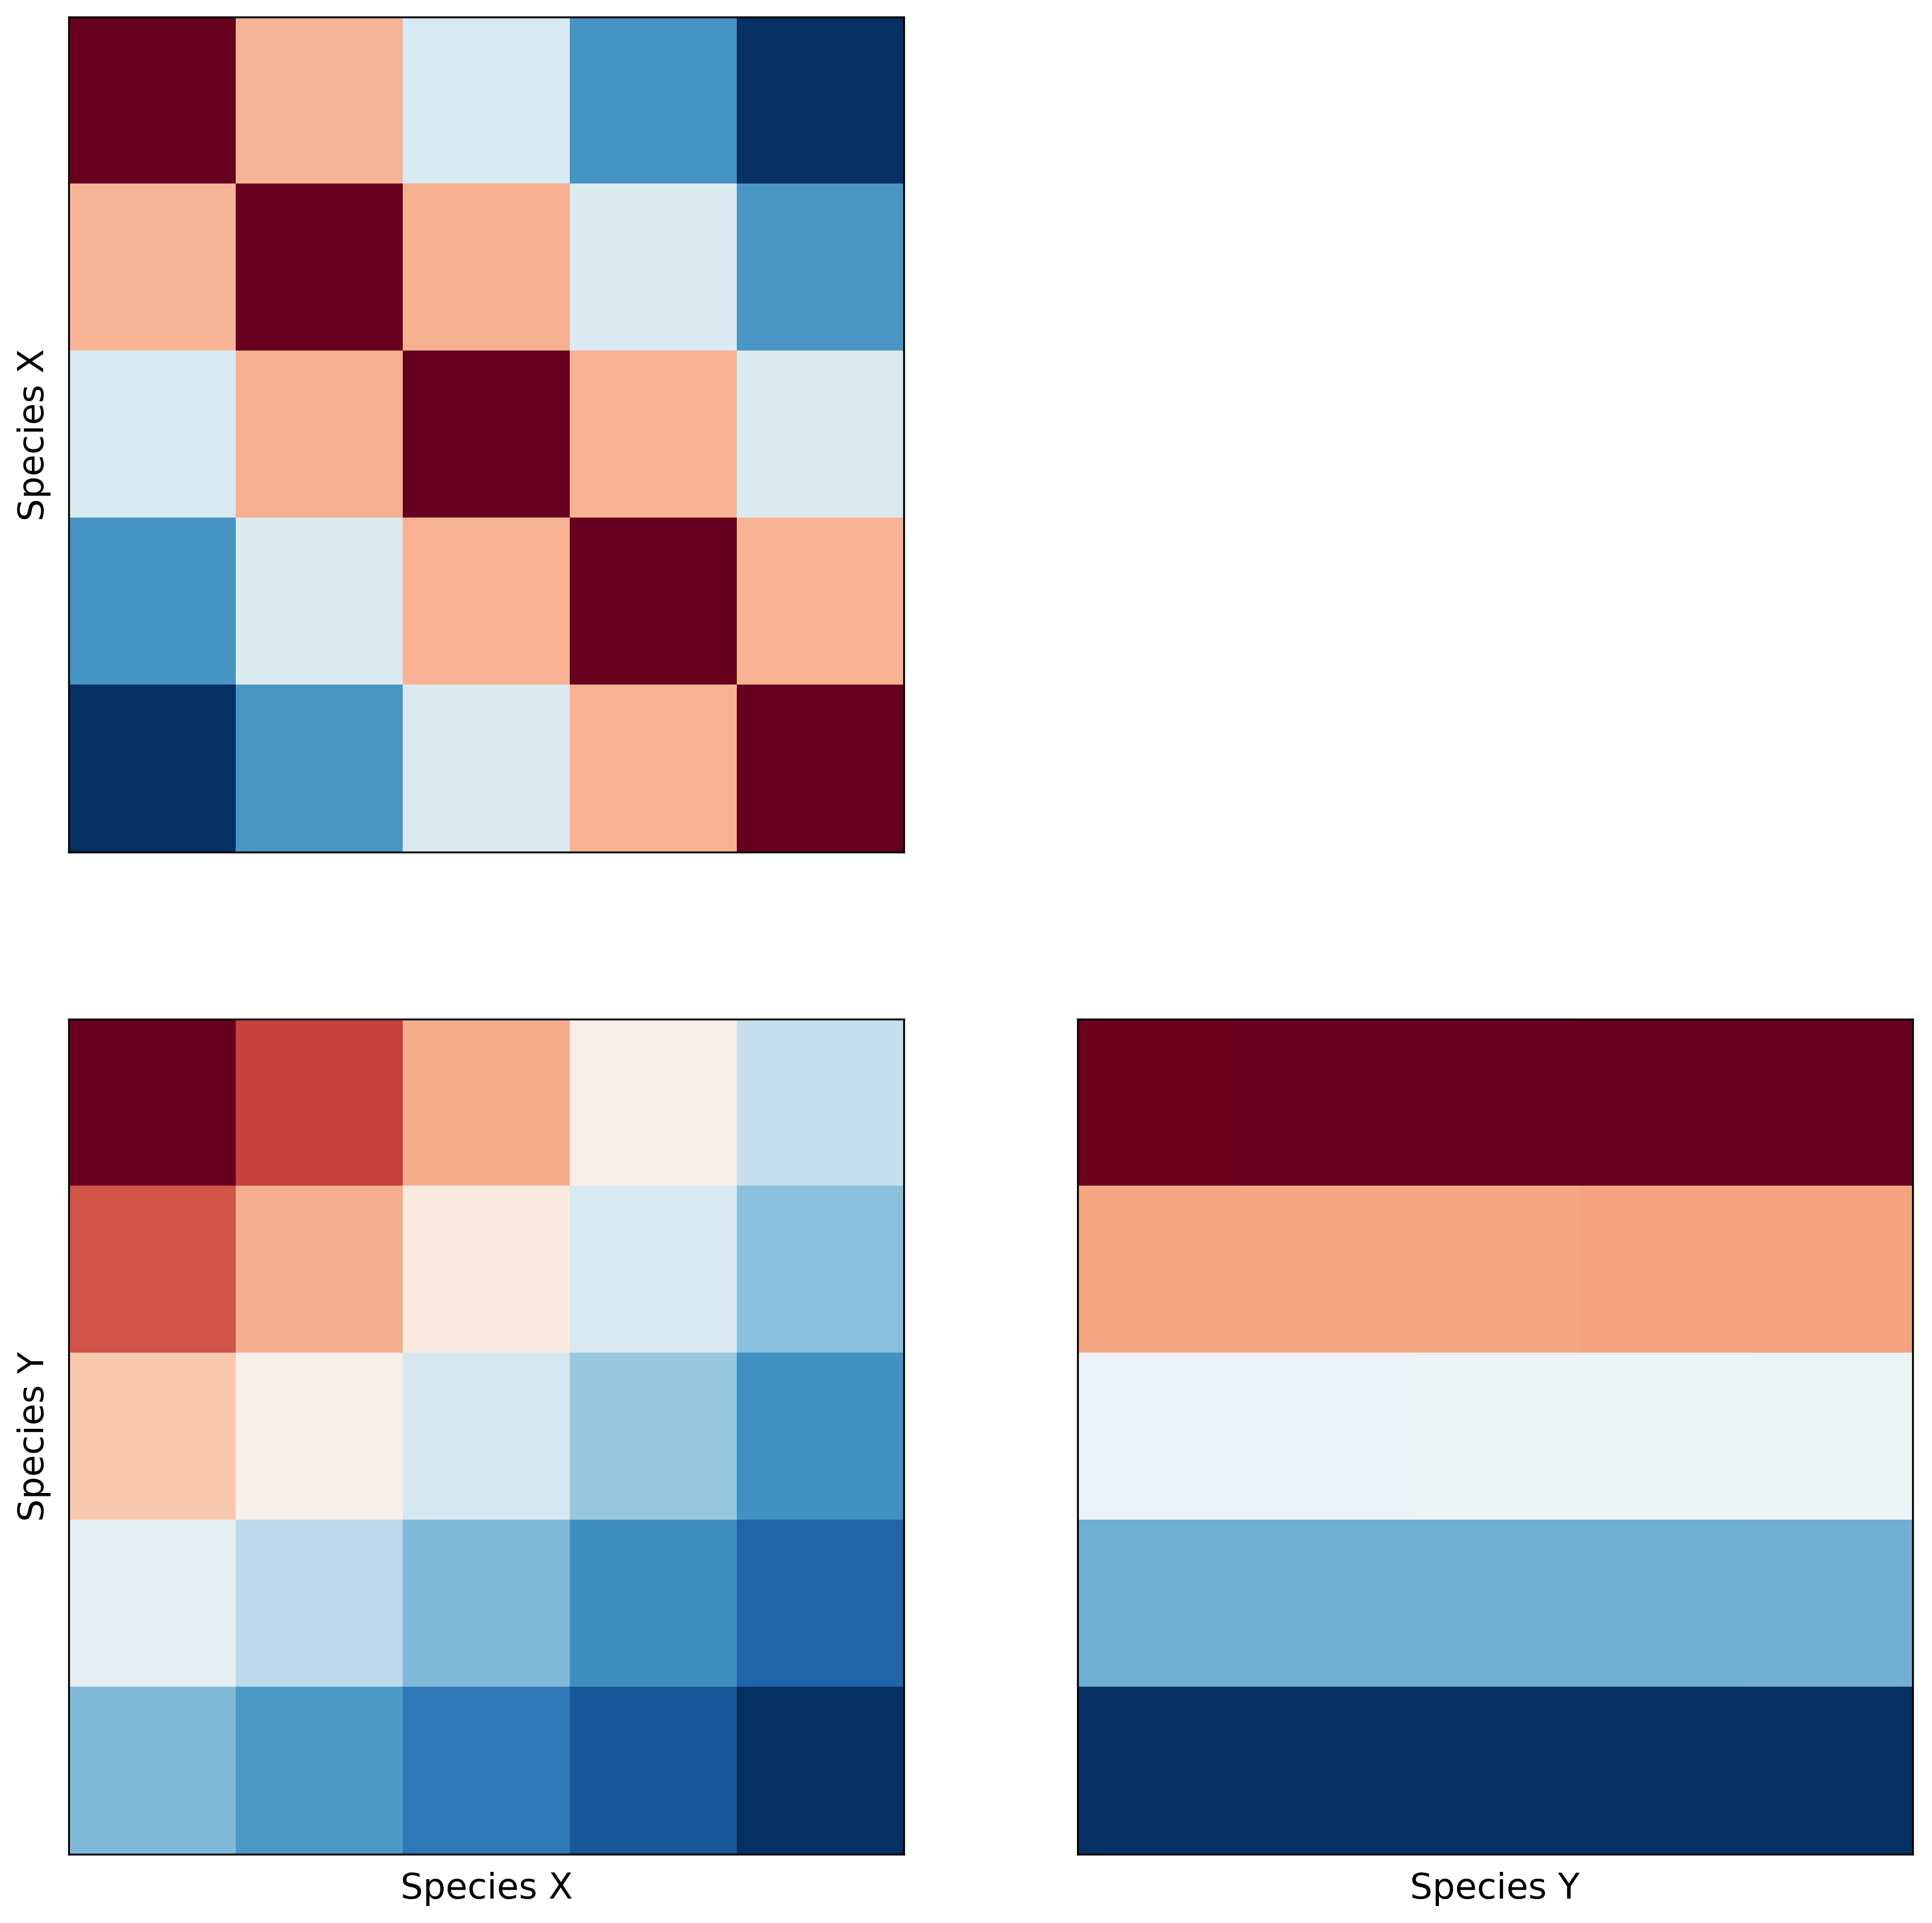

In [29]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 14), dpi=300)
axs[0, 1].axis('off')
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

corrs = np.zeros((vals_X_halved.shape[1], vals_X_halved.shape[1]))
for i in range(vals_X_halved.shape[1]):
    for j in range(vals_X_halved.shape[1]):
#         corrs[i, j] = np.corrcoef(vals_X_halved[:, i], vals_X_halved[:, j])[0, 1]
        corrs[i, j] = -jensen_shannon_distance(vals_X_halved[:, i], vals_X_halved[:, j])
axs[0, 0].imshow(corrs, cmap="RdBu_r", interpolation='None') #, vmin=-1, vmax=1)
axs[0, 0].set_ylabel("""Species X""")


corrs = np.zeros((vals_X_halved.shape[1], vals_Y_halved.shape[1]))
for i in range(vals_X_halved.shape[1]):
    for j in range(vals_Y_halved.shape[1]):
#         corrs[i, j] = np.corrcoef(vals_X_halved[:, i], vals_Y_halved[:, j])[0, 1]
        corrs[i, j] = -jensen_shannon_distance(vals_X_halved[:, i], vals_Y_halved[:, j])
axs[1, 0].imshow(corrs, cmap="RdBu_r", interpolation='None') #, vmin=-0.4, vmax=0.4)
axs[1, 0].set_xlabel("""Species X""")
axs[1, 0].set_ylabel("""Species Y""")


corrs = np.zeros((vals_Y_halved.shape[1], vals_Y_halved.shape[1]))
for i in range(vals_Y_halved.shape[1]):
    for j in range(vals_Y_halved.shape[1]):
        corrs[i, j] = np.corrcoef(vals_Y_halved[:, i], vals_Y_halved[:, j])[0, 1]
        corrs[i, j] = -jensen_shannon_distance(vals_Y_scaled[:, i], vals_Y_halved[:, j])
axs[1, 1].imshow(corrs, cmap="RdBu_r", interpolation='None') #, vmin=-1, vmax=1)
axs[1, 1].set_xlabel("""Species Y""")

# plt.colorbar()

# Another inverse hourglass after scaling!

But what if instead we scale and then cut our data in half. We pretend we never had the second half of data? That means we first would cut in half, and then afterwards do the scaling. If we scale after cutting the data in half, we get the same inverse hourglass again!?

Text(0.5, 0, 'Species Y')

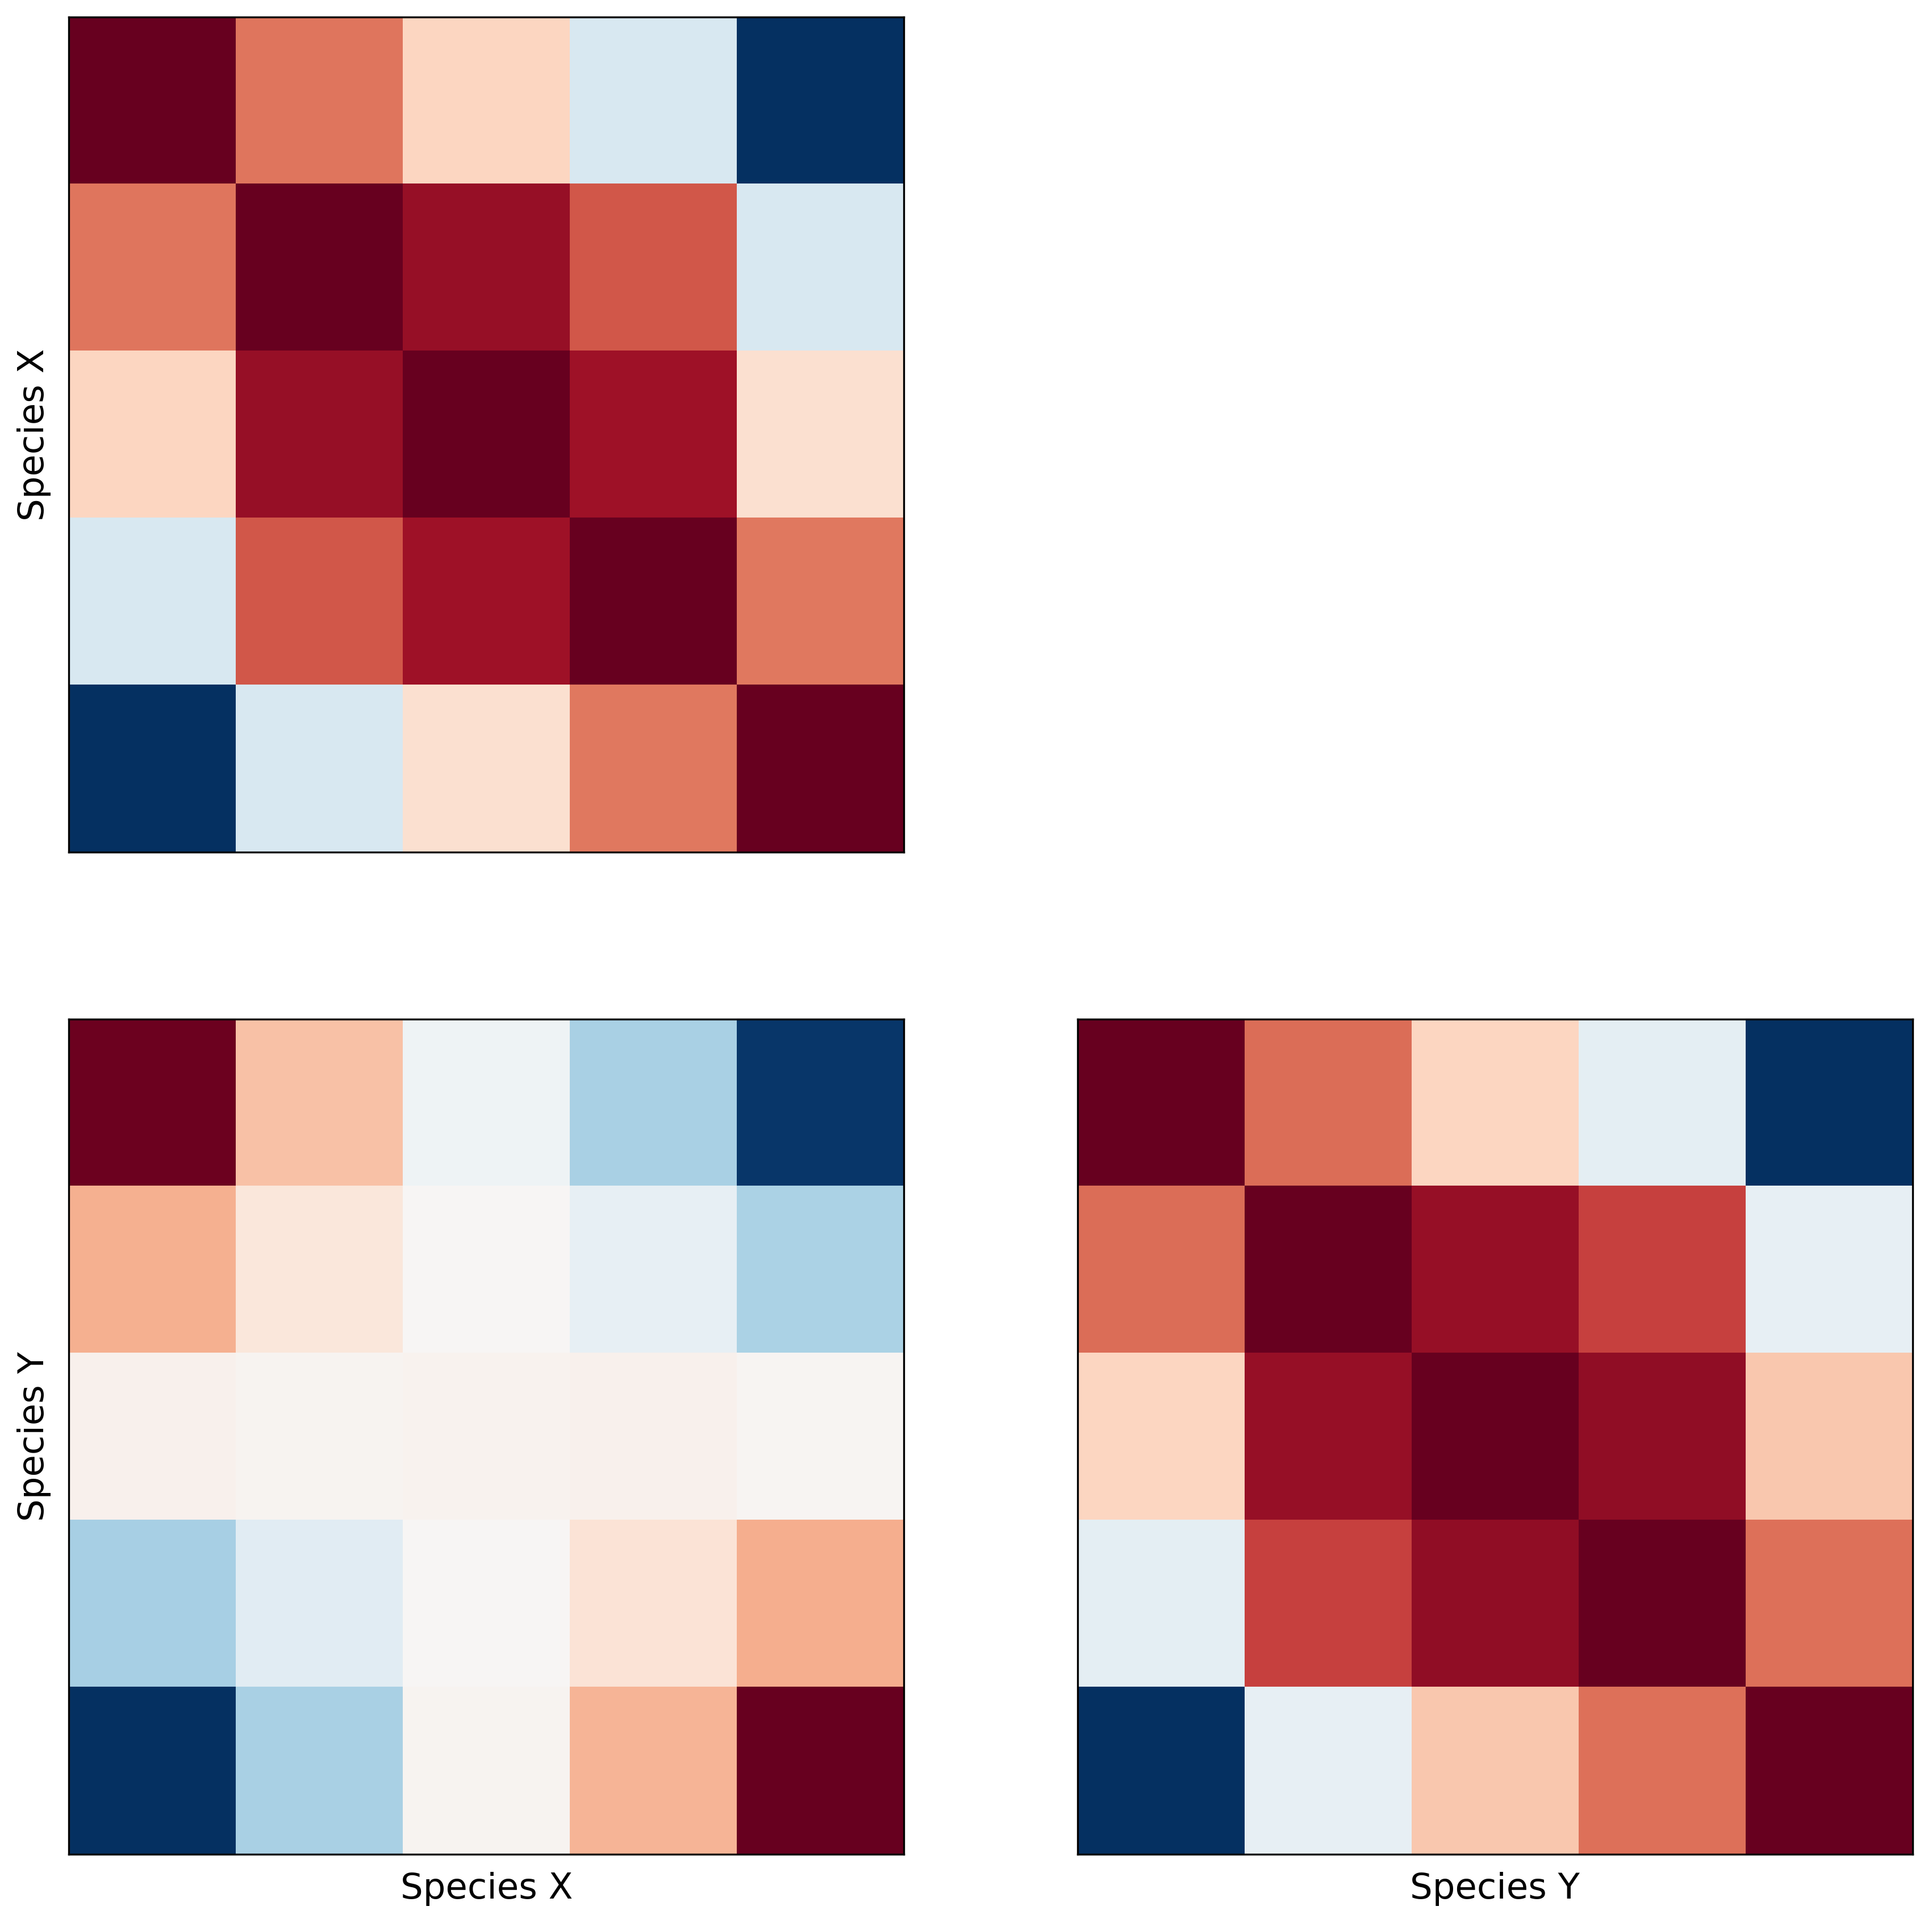

In [18]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 14), dpi=300)
axs[0, 1].axis('off')
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])


vals_X_halved_scaled = sklearn.preprocessing.minmax_scale(vals_X_halved, axis=1)
vals_Y_halved_scaled = sklearn.preprocessing.minmax_scale(vals_Y_halved, axis=1)

corrs = np.zeros((vals_X_halved_scaled.shape[1], vals_X_halved_scaled.shape[1]))
for i in range(vals_X_halved_scaled.shape[1]):
    for j in range(vals_X_halved_scaled.shape[1]):
        corrs[i, j] = stats.spearmanr(vals_X_halved_scaled[:, i], vals_X_halved_scaled[:, j])[0]
#         corrs[i, j] = np.corrcoef(vals_X_halved_scaled[:, i], vals_X_halved_scaled[:, j])[0, 1]
#         corrs[i, j] = -np.linalg.norm(vals_X_halved_scaled[:, i] - vals_X_halved_scaled[:, j])
#         corrs[i, j] = -jensen_shannon_distance(vals_X_halved_scaled[:, i], vals_X_halved_scaled[:, j])
axs[0, 0].imshow(corrs, cmap="RdBu_r", interpolation='None') #, vmin=-1, vmax=1)
axs[0, 0].set_ylabel("""Species X""")


corrs = np.zeros((vals_X_halved_scaled.shape[1], vals_Y_halved_scaled.shape[1]))
for i in range(vals_X_halved_scaled.shape[1]):
    for j in range(vals_Y_halved.shape[1]):
        corrs[i, j] = stats.spearmanr(vals_X_halved_scaled[:, i], vals_Y_halved_scaled[:, j])[0]
#         corrs[i, j] = np.corrcoef(vals_X_halved_scaled[:, i], vals_Y_halved_scaled[:, j])[0, 1]
#         corrs[i, j] = -np.linalg.norm(vals_X_halved_scaled[:, i] - vals_Y_halved_scaled[:, j])
#         corrs[i, j] = -jensen_shannon_distance(vals_X_halved_scaled[:, i], vals_Y_halved_scaled[:, j])
axs[1, 0].imshow(corrs, cmap="RdBu_r", interpolation='None') #, vmin=-1, vmax=1)
axs[1, 0].set_xlabel("""Species X""")
axs[1, 0].set_ylabel("""Species Y""")


corrs = np.zeros((vals_Y_halved_scaled.shape[1], vals_Y_halved_scaled.shape[1]))
for i in range(vals_Y_halved_scaled.shape[1]):
    for j in range(vals_Y_halved.shape[1]):
        corrs[i, j] = stats.spearmanr(vals_Y_halved_scaled[:, i], vals_Y_halved_scaled[:, j])[0]
#         corrs[i, j] = np.corrcoef(vals_Y_halved_scaled[:, i], vals_Y_halved_scaled[:, j])[0, 1]
#         corrs[i, j] = -np.linalg.norm(vals_Y_halved_scaled[:, i] - vals_Y_halved_scaled[:, j])
#         corrs[i, j] = -jensen_shannon_distance(vals_Y_halved_scaled[:, i], vals_Y_halved_scaled[:, j])

axs[1, 1].imshow(corrs, cmap="RdBu_r", interpolation='None') #, vmin=-1, vmax=1)
axs[1, 1].set_xlabel("""Species Y""")

# Is the inverse hourglass real?

The simulated data seems to indicate the inverse hourglass is an artefact of scaling

[10 20 28 35 41 45 47 49 51 53 55 59 65 72 80 90]


Text(0.5, 1.0, 'inverse hourglass')

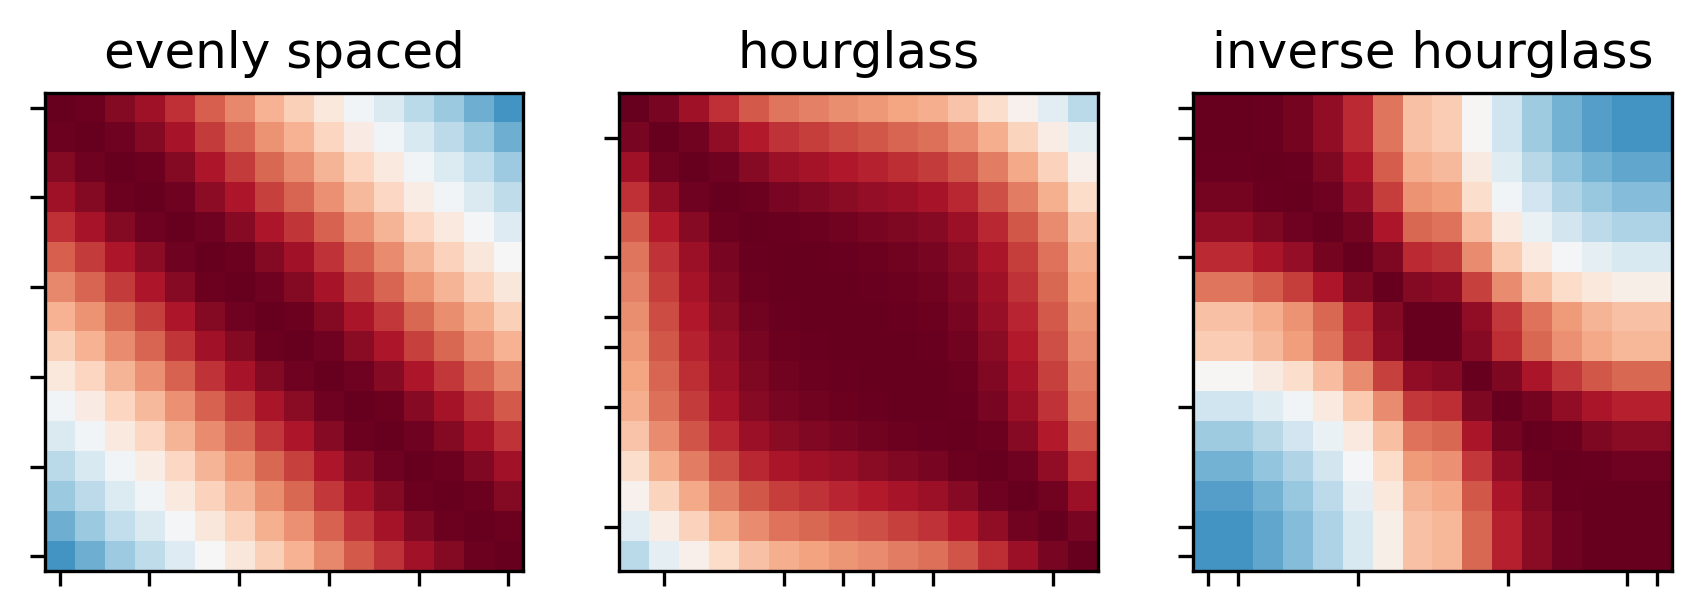

In [19]:
visualize_timepoints = 16
nr_ticks = 6

genes = 500
timepoints = 100
switch_duration = timepoints//3
vals_X, *_ = get_switch_simdata(genes, timepoints, switch_duration, 1)

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(7, 7), dpi=300)

# linear sampled
corrs = np.zeros((visualize_timepoints, visualize_timepoints))
idxs = np.linspace(0, timepoints-1, visualize_timepoints).astype(int)
for i in range(corrs.shape[0]):
    for j in range(corrs.shape[1]):
        corrs[i, j] = np.corrcoef(vals_X[:, idxs[i]], vals_X[:, idxs[j]])[0, 1]
        
# corrs = np.ma.masked_where(np.triu(corrs, k=1), corrs)
# axs[0].spines[['right', 'top']].set_visible(False)

axs[0].imshow(corrs, cmap="RdBu_r", interpolation='None', vmin=-1, vmax=1)
axs[0].set_xticks(np.round(np.linspace(0, len(idxs) - 1, nr_ticks)).astype(int))
axs[0].set_xticklabels(["" for i in range(nr_ticks)])
axs[0].set_yticks(np.round(np.linspace(0, len(idxs) - 1, nr_ticks)).astype(int))
axs[0].set_yticklabels(["" for i in range(nr_ticks)])
axs[0].set_title("evenly spaced")


# hourglass sampled
corrs = np.zeros((visualize_timepoints, visualize_timepoints))
idxs = 5 + np.linspace(timepoints//2, 0, num=visualize_timepoints//2).astype(int)
idxs = np.cumsum(idxs)
idxs = ((timepoints//2) * idxs / idxs[-1]).astype(int) - 1
idxs = np.clip(np.concatenate([idxs, timepoints - idxs[::-1]]), 0, timepoints-1)
print(idxs)
for i in range(corrs.shape[0]):
    for j in range(corrs.shape[1]):
        corrs[i, j] = np.corrcoef(vals_X[:, idxs[i]], vals_X[:, idxs[j]])[0, 1]
axs[1].imshow(corrs, cmap="RdBu_r", interpolation='None', vmin=-1, vmax=1)

axs[1].set_xticks(idxs[np.round(np.linspace(0, len(idxs) - 1, nr_ticks)).astype(int)] // (timepoints / visualize_timepoints))
axs[1].set_xticklabels(["" for i in range(nr_ticks)])
axs[1].set_yticks(idxs[np.round(np.linspace(0, len(idxs) - 1, nr_ticks)).astype(int)] // (timepoints / visualize_timepoints))
axs[1].set_yticklabels(["" for i in range(nr_ticks)])
axs[1].set_title("hourglass")


corrs = np.zeros((visualize_timepoints, visualize_timepoints))
idxs = np.linspace(0, timepoints//2, num=visualize_timepoints//2).astype(int)
idxs = np.cumsum(idxs)
idxs = ((timepoints//2) * idxs / idxs[-1]).astype(int) - 1
idxs = np.clip(np.concatenate([idxs, timepoints - idxs[::-1]]), 0, timepoints-1)
for i in range(corrs.shape[0]):
    for j in range(corrs.shape[1]):
        corrs[i, j] = np.corrcoef(vals_X[:, idxs[i]], vals_X[:, idxs[j]])[0, 1]
axs[2].imshow(corrs, cmap="RdBu_r", interpolation='None', vmin=-1, vmax=1)
axs[2].set_xticks(idxs[np.round(np.linspace(0, len(idxs) - 1, nr_ticks)).astype(int)] // (timepoints / visualize_timepoints))
axs[2].set_xticklabels(["" for i in range(nr_ticks)])
axs[2].set_yticks(idxs[np.round(np.linspace(0, len(idxs) - 1, nr_ticks)).astype(int)] // (timepoints / visualize_timepoints))
axs[2].set_yticklabels(["" for i in range(nr_ticks)])
axs[2].set_title("inverse hourglass")

[Text(0, 0, ''),
 Text(0, 3, ''),
 Text(0, 6, ''),
 Text(0, 9, ''),
 Text(0, 12, ''),
 Text(0, 15, '')]

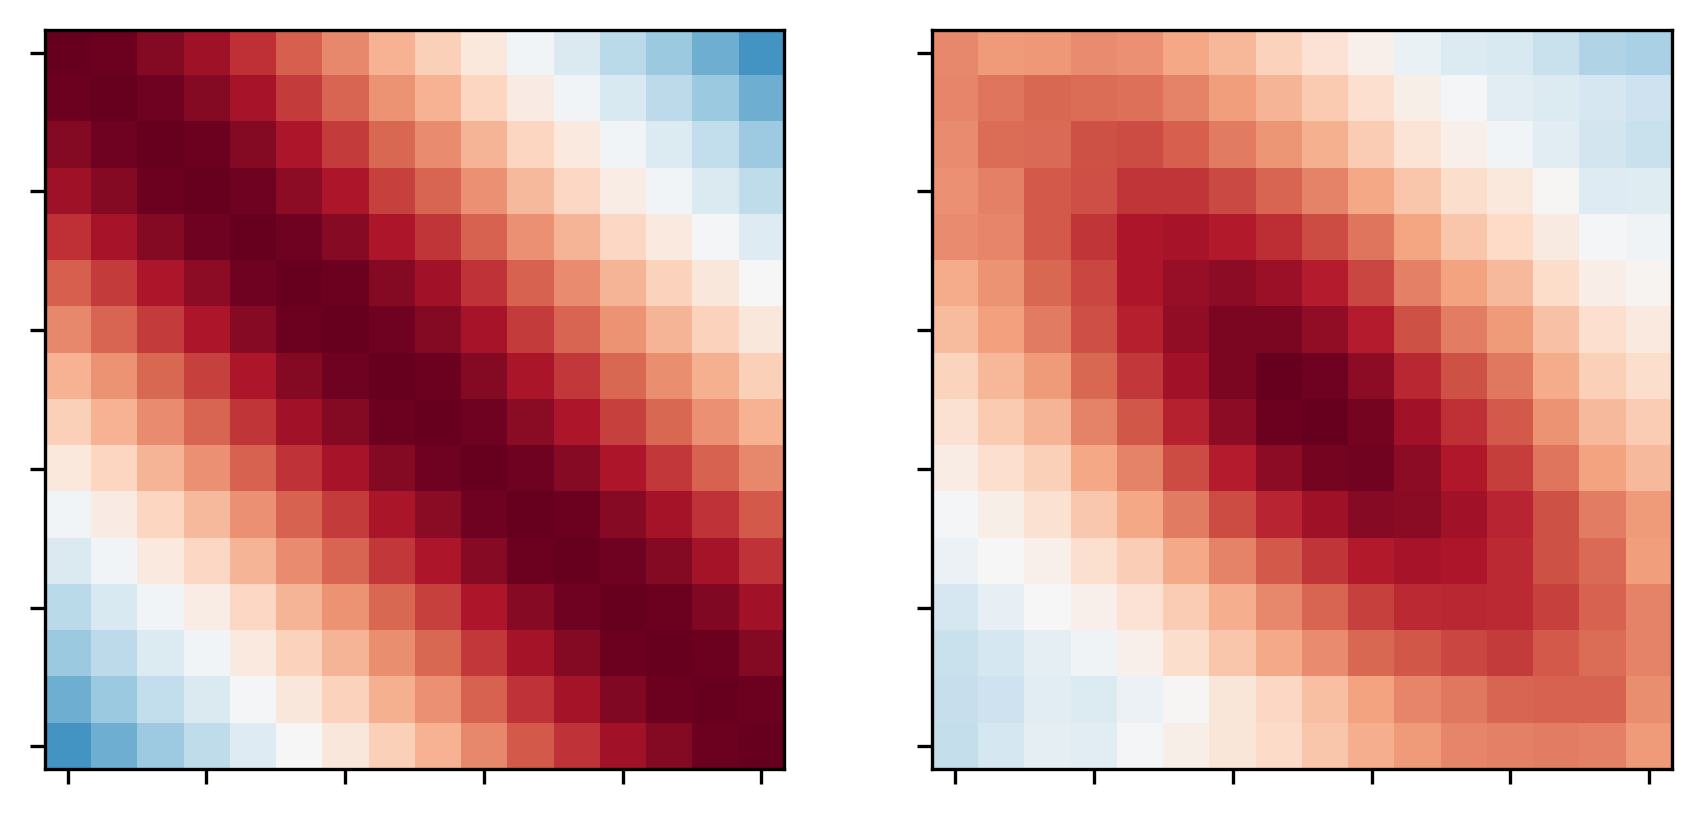

In [20]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(7, 7), dpi=300)


# linear sampled
corrs = np.zeros((visualize_timepoints, visualize_timepoints))
idxs = np.linspace(0, timepoints-1, visualize_timepoints).astype(int)
for i in range(corrs.shape[0]):
    for j in range(corrs.shape[1]):
        corrs[i, j] = np.corrcoef(vals_X[:, idxs[i]], vals_X[:, idxs[j]])[0, 1]
axs[0].imshow(corrs, cmap="RdBu_r", interpolation='None', vmin=-1, vmax=1)
axs[0].set_xticks(np.round(np.linspace(0, len(idxs) - 1, nr_ticks)).astype(int))
axs[0].set_xticklabels(["" for i in range(nr_ticks)])
axs[0].set_yticks(np.round(np.linspace(0, len(idxs) - 1, nr_ticks)).astype(int))
axs[0].set_yticklabels(["" for i in range(nr_ticks)])




variance = np.array([np.abs(i - (timepoints // 2)) for i in range(timepoints)]) / timepoints

vals_X_noise = vals_X + np.random.normal(loc=0.0, scale=variance, size=(genes, timepoints))
vals_Y_noise = vals_X + np.random.normal(loc=0.0, scale=variance, size=(genes, timepoints))

corrs = np.zeros((visualize_timepoints, visualize_timepoints))
idxs = np.linspace(0, timepoints-1, visualize_timepoints).astype(int)
for i in range(corrs.shape[0]):
    for j in range(corrs.shape[1]):
        corrs[i, j] = np.corrcoef(vals_X_noise[:, idxs[i]], vals_Y_noise[:, idxs[j]])[0, 1]
axs[1].imshow(corrs, cmap="RdBu_r", interpolation='None', vmin=-1, vmax=1)
axs[1].set_xticks(np.round(np.linspace(0, len(idxs) - 1, nr_ticks)).astype(int))
axs[1].set_xticklabels(["" for i in range(nr_ticks)])
axs[1].set_yticks(np.round(np.linspace(0, len(idxs) - 1, nr_ticks)).astype(int))
axs[1].set_yticklabels(["" for i in range(nr_ticks)])




In [23]:
vals_X

array([[0.     , 0.     , 0.     , ..., 1.     , 1.     , 1.     ],
       [0.     , 0.     , 0.     , ..., 0.65625, 0.6875 , 0.71875],
       [0.     , 0.     , 0.03125, ..., 1.     , 1.     , 1.     ],
       ...,
       [1.     , 1.     , 1.     , ..., 0.09375, 0.0625 , 0.03125],
       [1.     , 1.     , 1.     , ..., 0.78125, 0.75   , 0.71875],
       [1.     , 1.     , 1.     , ..., 0.     , 0.     , 0.     ]])

In [64]:
127.116 / 2

63.558